<a href="https://colab.research.google.com/github/SamuellAguiar/Trabalho2_SAD/blob/main/Trabalho_Final_de_SAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Análise de Comorbidades

Este notebook apresenta análises sobre a ocorrência e relação entre diferentes doenças crônicas, com segmentação por **Gênero**, **Faixa Etária** e **Raça/Cor**. Os dados são carregados a partir do Google Drive e processados para gerar estatísticas, correlações e clusters.

## 1️⃣ Configuração do Ambiente

Nesta seção, importamos as bibliotecas necessárias e montamos o Google Drive para acesso aos dados.

In [ ]:
import warnings
warnings.filterwarnings("ignore", module="jupyter_client")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import networkx as nx
from google.colab import drive
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import fisher_exact, chi2_contingency
from matplotlib_venn import venn2
print('Bibliotecas importadas com sucesso!')

drive.mount('/content/drive', force_remount=True)
print('')

Bibliotecas importadas com sucesso!
Mounted at /content/drive



## 2️⃣ Carregamento e Preparação dos Dados

- Leitura do arquivo `.xlsx` com dados binários.
- Definição das colunas de interesse.
- Criação de `df_fem` e `df_masc` para análises segmentadas.

In [ ]:
caminho_arquivo = '/content/drive/MyDrive/DataBaseSAD/DataBaseProcessedBinary.xlsx'
df = pd.read_excel(caminho_arquivo)

print("Dados carregados com sucesso!")

Dados carregados com sucesso!


In [ ]:
colunas_doencas = [
    # Doenças e Condições
    'Colesterol Alto', 'AVC ou Derrame', 'Asma', 'Artrite ou Reumatismo', 'Dor na Coluna',
    'DORT', 'Depressão', 'Hipertensão', 'Diabetes', 'Cardiopatia', 'Câncer',
    'Insuficiência Renal Crônica', 'Doença Mental', 'Doença Crônica no Pulmão',

    # Fatores de Risco e Hábitos
    'Exercício Físico', 'Tabaco', 'Álcool',

    # Novas Colunas de IMC
    'Baixo Peso', 'Peso Normal', 'Sobrepeso', 'Obesidade'
]

In [ ]:
df_fem = df[df['Mulher'] == 1][colunas_doencas]
df_masc = df[df['Homem'] == 1][colunas_doencas]

## 3️⃣ Análise por Gênero

Aplicamos o algoritmo Apriori para encontrar regras de associação entre doenças com base no suporte, confiança e lift.

3️⃣.1️⃣ Geração de Regras de Associação

In [ ]:
def gerar_regras_mlxtend(data, min_suporte=0.02, min_confianca=0.2):
    data_bool = data.astype(bool)
    itemsets_frequentes = apriori(data_bool, min_support=min_suporte, use_colnames=True, max_len=3)

    if itemsets_frequentes.empty:
        print("Nenhum itemset frequente encontrado com o suporte mínimo fornecido.")
        return pd.DataFrame()

    regras = association_rules(itemsets_frequentes, metric="lift", min_threshold=1.0)
    regras_filtradas = regras[(regras['confidence'] >= min_confianca) & (regras['antecedent support'] < 0.8) & (regras['support'] < 0.8)].copy()

    if regras_filtradas.empty:
        print("Nenhuma regra de associação encontrada após aplicar os filtros.")
        return pd.DataFrame()

    regras_filtradas['antecedente'] = regras_filtradas['antecedents'].apply(lambda x: ', '.join(list(x)))
    regras_filtradas['consequente'] = regras_filtradas['consequents'].apply(lambda x: ', '.join(list(x)))
    regras_finais = regras_filtradas[['antecedente', 'consequente', 'support', 'confidence', 'lift']].rename(columns={'support': 'suporte', 'confidence': 'confianca'})
    return regras_finais.sort_values(by='lift', ascending=False).reset_index(drop=True)

In [ ]:
from IPython.display import display

regras_fem_novo = gerar_regras_mlxtend(df_fem)

print("\n--- Top 15 Regras de Associação (Feminino) ---")

if not regras_fem_novo.empty:
    tabela_para_plotar = regras_fem_novo.head(15)

    tabela_simples_e_organizada = tabela_para_plotar.style \
        .format({
            'suporte': '{:.2%}',
            'confianca': '{:.2%}',
            'lift': '{:.2f}'
        }) \
        .set_caption("Top 15 Regras de Associação (Feminino)") \
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('caption-side', 'top'),
                ('font-size', '14pt'),
                ('font-weight', 'bold'),
                ('color', '#333'),
                ('margin-bottom', '10px')
            ]},
            {'selector': 'th', 'props': [
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('background-color', '#000000')
            ]},
            {'selector': 'td', 'props': [
                ('text-align', 'center'),
                ('border', '1px solid #eee')
            ]}
        ])

    # Exibe a tabela
    display(tabela_simples_e_organizada)

else:
    print("Nenhuma regra encontrada para o sexo feminino com os parâmetros definidos.")


--- Top 15 Regras de Associação (Feminino) ---


,antecedente,consequente,suporte,confianca,lift
0,Depressão,Doença Mental,3.69%,27.14%,3.69
1,Doença Mental,Depressão,3.69%,50.12%,3.69
2,"Hipertensão, Colesterol Alto",Diabetes,3.31%,30.92%,3.20
3,Diabetes,"Hipertensão, Colesterol Alto",3.31%,34.26%,3.20
4,Artrite ou Reumatismo,"Colesterol Alto, Dor na Coluna",2.78%,23.31%,3.13
5,"Colesterol Alto, Dor na Coluna",Artrite ou Reumatismo,2.78%,37.40%,3.13
6,"Dor na Coluna, Depressão",Artrite ou Reumatismo,2.06%,36.82%,3.08
7,"Hipertensão, Dor na Coluna",Artrite ou Reumatismo,3.72%,35.57%,2.98
8,Artrite ou Reumatismo,"Hipertensão, Dor na Coluna",3.72%,31.16%,2.98
9,"Artrite ou Reumatismo, Depressão",Dor na Coluna,2.06%,66.06%,2.77


In [ ]:
print("\nGerando regras de associação para o sexo masculino...")

regras_masc_novo = gerar_regras_mlxtend(df_masc)

if not regras_masc_novo.empty:
    tabela_para_plotar = regras_masc_novo.head(15)

    tabela_simples_e_organizada = tabela_para_plotar.style \
        .format({
            'suporte': '{:.2%}',
            'confianca': '{:.2%}',
            'lift': '{:.2f}'
        }) \
        .set_caption("Top 15 Regras de Associação (Feminino)") \
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('caption-side', 'top'),
                ('font-size', '14pt'),
                ('font-weight', 'bold'),
                ('color', '#333'),
                ('margin-bottom', '10px')
            ]},
            {'selector': 'th', 'props': [
                ('text-align', 'center'),
                ('font-weight', 'bold'),
                ('background-color', '#000000')
            ]},
            {'selector': 'td', 'props': [
                ('text-align', 'center'),
                ('border', '1px solid #eee')
            ]}
        ])

    display(tabela_simples_e_organizada)

else:
    print("Nenhuma regra encontrada para o sexo feminino com os parâmetros definidos.")


Gerando regras de associação para o sexo masculino...


,antecedente,consequente,suporte,confianca,lift
0,Diabetes,Colesterol Alto,2.44%,35.30%,3.18
1,Colesterol Alto,Diabetes,2.44%,21.95%,3.18
2,Cardiopatia,Hipertensão,2.95%,60.10%,2.67
3,Diabetes,Hipertensão,4.13%,59.76%,2.66
4,"Exercício Físico, Hipertensão",Colesterol Alto,2.10%,26.55%,2.39
5,Hipertensão,Colesterol Alto,5.68%,25.25%,2.27
6,Colesterol Alto,Hipertensão,5.68%,51.17%,2.27
7,Colesterol Alto,"Sobrepeso, Hipertensão",2.40%,21.56%,2.26
8,"Sobrepeso, Hipertensão",Colesterol Alto,2.40%,25.14%,2.26
9,"Sobrepeso, Colesterol Alto",Hipertensão,2.40%,48.19%,2.14


### 3️⃣.2️⃣ - Interpretando as Regras de Associação

In [ ]:
def interpretar_regras(regras, sexo, top_n=5):
    print(f"\n--- Análise das Top {top_n} Regras para o Sexo {sexo} (por Lift) ---\n")

    if regras.empty:
        print(f"Nenhuma regra para analisar no sexo {sexo}.")
        return

    for i, row in regras.head(top_n).iterrows():
        antecedente = row['antecedente']
        consequente = row['consequente']
        confianca = row['confianca'] * 100
        lift = row['lift']

        print(f"Regra {i+1}:")
        print(f"  SE uma pessoa tem [{antecedente}],")
        print(f"  ENTÃO há uma chance de {confianca:.2f}% dela também ter [{consequente}].")
        print(f"  --> Essa associação é {lift:.2f} vezes mais forte do que o esperado por acaso (Lift).\n")

In [ ]:
interpretar_regras(regras_fem_novo, "Feminino")


--- Análise das Top 5 Regras para o Sexo Feminino (por Lift) ---

Regra 1:
  SE uma pessoa tem [Depressão],
  ENTÃO há uma chance de 27.14% dela também ter [Doença Mental].
  --> Essa associação é 3.69 vezes mais forte do que o esperado por acaso (Lift).

Regra 2:
  SE uma pessoa tem [Doença Mental],
  ENTÃO há uma chance de 50.12% dela também ter [Depressão].
  --> Essa associação é 3.69 vezes mais forte do que o esperado por acaso (Lift).

Regra 3:
  SE uma pessoa tem [Hipertensão, Colesterol Alto],
  ENTÃO há uma chance de 30.92% dela também ter [Diabetes].
  --> Essa associação é 3.20 vezes mais forte do que o esperado por acaso (Lift).

Regra 4:
  SE uma pessoa tem [Diabetes],
  ENTÃO há uma chance de 34.26% dela também ter [Hipertensão, Colesterol Alto].
  --> Essa associação é 3.20 vezes mais forte do que o esperado por acaso (Lift).

Regra 5:
  SE uma pessoa tem [Artrite ou Reumatismo],
  ENTÃO há uma chance de 23.31% dela também ter [Colesterol Alto, Dor na Coluna].
  --> Ess

In [ ]:
interpretar_regras(regras_masc_novo, "Masculino")


--- Análise das Top 5 Regras para o Sexo Masculino (por Lift) ---

Regra 1:
  SE uma pessoa tem [Diabetes],
  ENTÃO há uma chance de 35.30% dela também ter [Colesterol Alto].
  --> Essa associação é 3.18 vezes mais forte do que o esperado por acaso (Lift).

Regra 2:
  SE uma pessoa tem [Colesterol Alto],
  ENTÃO há uma chance de 21.95% dela também ter [Diabetes].
  --> Essa associação é 3.18 vezes mais forte do que o esperado por acaso (Lift).

Regra 3:
  SE uma pessoa tem [Cardiopatia],
  ENTÃO há uma chance de 60.10% dela também ter [Hipertensão].
  --> Essa associação é 2.67 vezes mais forte do que o esperado por acaso (Lift).

Regra 4:
  SE uma pessoa tem [Diabetes],
  ENTÃO há uma chance de 59.76% dela também ter [Hipertensão].
  --> Essa associação é 2.66 vezes mais forte do que o esperado por acaso (Lift).

Regra 5:
  SE uma pessoa tem [Exercício Físico, Hipertensão],
  ENTÃO há uma chance de 26.55% dela também ter [Colesterol Alto].
  --> Essa associação é 2.39 vezes mais fort

### 3️⃣.3️⃣ - Visualização dessas Regras

In [ ]:
def plotar_grafo_regras(regras, titulo):

    regras_plot = regras.head(15).copy()

    if regras_plot.empty:
        print(f"Nenhuma regra encontrada para plotar o gráfico: {titulo}")
        return

    G = nx.DiGraph()

    for _, row in regras_plot.iterrows():
        antecedente = row['antecedente']
        consequente = row['consequente']

        G.add_node(antecedente)
        G.add_node(consequente)

        G.add_edge(antecedente, consequente, weight=row['lift'])

    plt.figure(figsize=(12, 9))

    pos = nx.spring_layout(G, k=5, iterations=50, seed=42)

    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue', alpha=0.9,
                           linewidths=1, edgecolors='black')

    nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif', font_weight='bold')

    nx.draw_networkx_edges(G, pos,
                           edge_color='gray',
                           width=2.0,
                           alpha=0.8,
                           arrowsize=15,
                           node_size=1000,
                           connectionstyle='arc3,rad=0.1')

    edge_labels = nx.get_edge_attributes(G, 'weight')
    formatted_edge_labels = {k: f"Lift: {v:.2f}" for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos,
                                 edge_labels=formatted_edge_labels,
                                 font_color='black',
                                 font_size=9,
                                 font_weight='bold',
                                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

    plt.title(titulo, size=24, pad=20)
    plt.margins(0.1)
    plt.axis('off')

    plt.show()

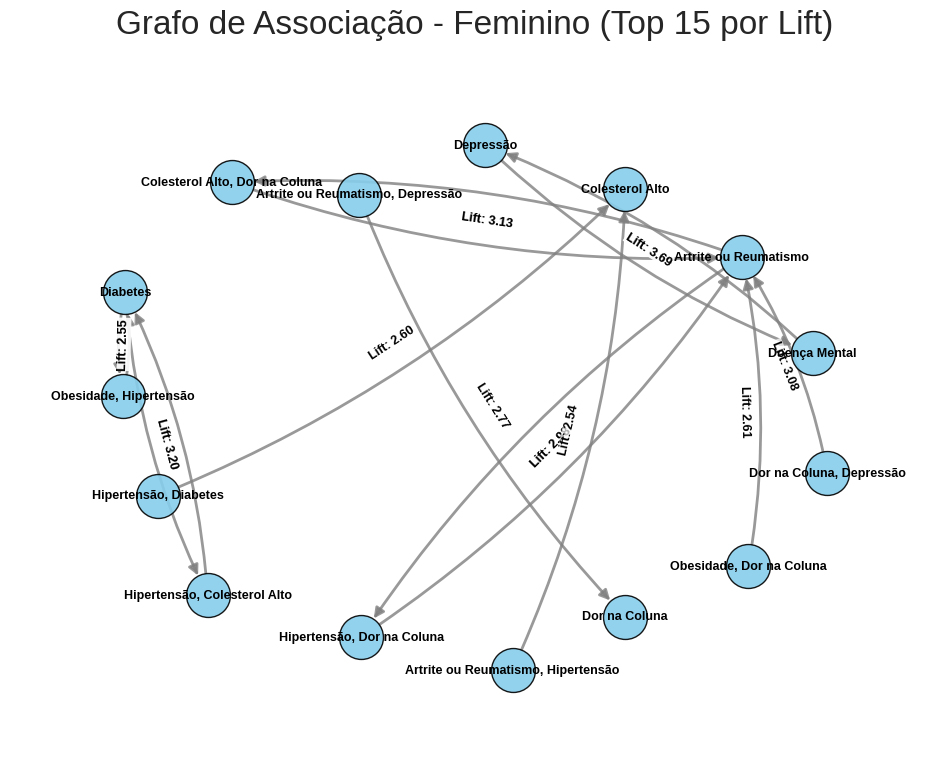

In [ ]:
plotar_grafo_regras(regras_fem_novo, "Grafo de Associação - Feminino (Top 15 por Lift)")

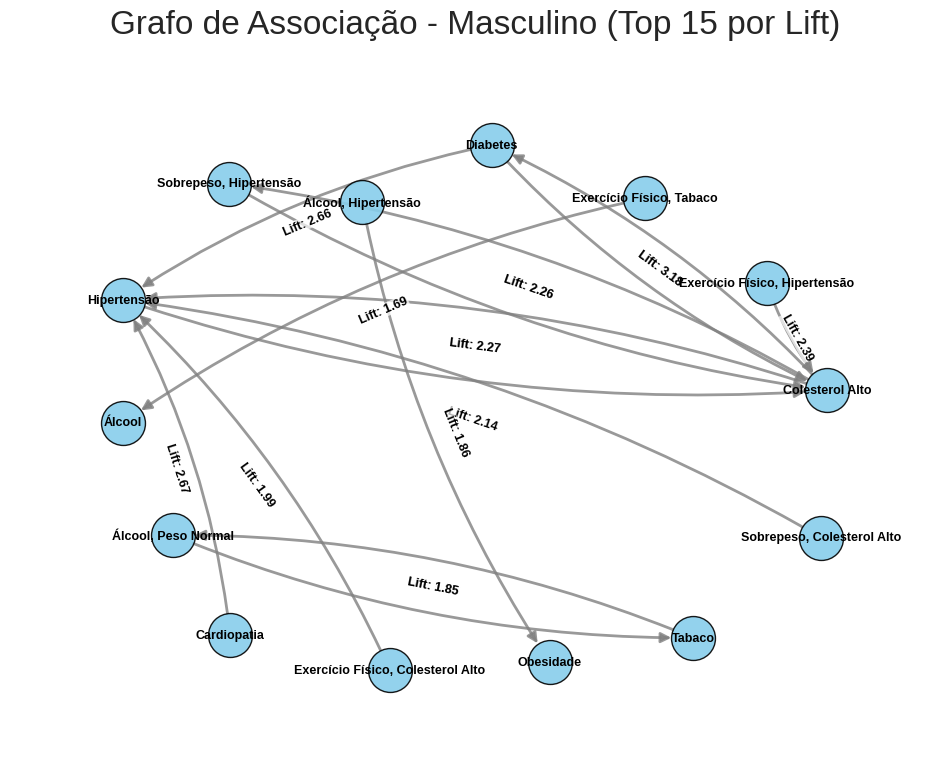

In [ ]:
plotar_grafo_regras(regras_masc_novo, "Grafo de Associação - Masculino (Top 15 por Lift)")

## 4️⃣ Correlação entre Doenças

Analisamos as correlações entre doenças usando mapas de calor e gráficos simplificados.

### 4️⃣.1️⃣ Prevalência de Doenças por Gênero

In [ ]:
def prevalencia_por_genero(df, colunas_doencas):
    prevalencias = df[colunas_doencas].mean().sort_values(ascending=False)
    return prevalencias
    print("\nCalculando prevalência por doença para cada gênero...")
prev_fem = prevalencia_por_genero(df_fem, colunas_doencas)
prev_masc = prevalencia_por_genero(df_masc, colunas_doencas)

In [ ]:
def grafico_prevalencia_lado_a_lado(prev_fem, prev_masc):
    df_prev = pd.DataFrame({'Feminino': prev_fem, 'Masculino': prev_masc})
    df_prev = df_prev.sort_values(by='Feminino', ascending=False)
    df_prev.plot(kind='bar', figsize=(10,6), color=['#FF0000', '#0000FF'])
    plt.title("Prevalência de Doenças por Gênero", fontsize=18, fontweight='bold')
    plt.ylabel("Proporção de indivíduos com a doença", fontsize=14)
    plt.xlabel("Doenças", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.show()
    plt.close()


Gerando gráfico de prevalência lado a lado...


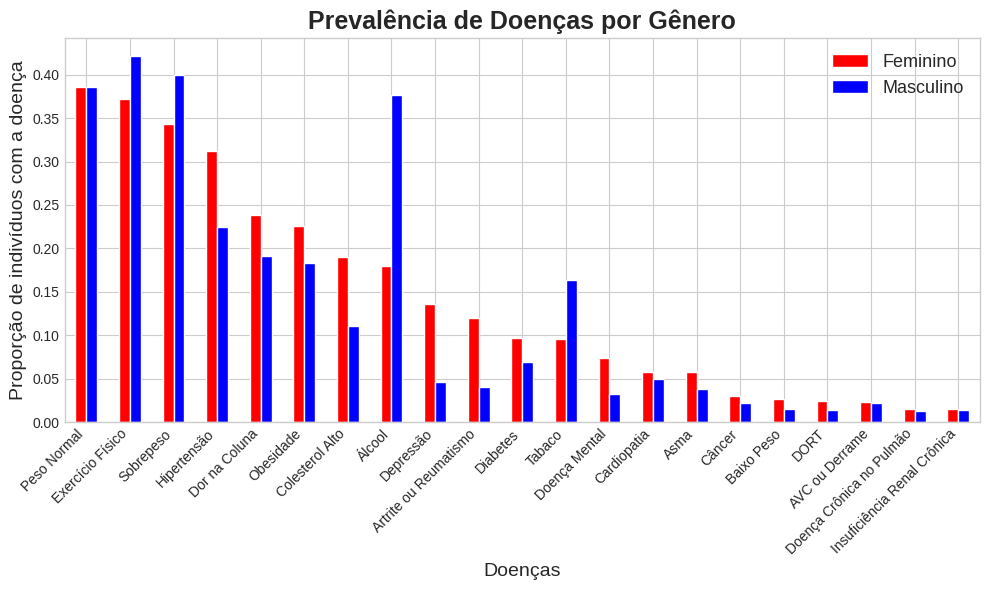

In [ ]:
print("\nGerando gráfico de prevalência lado a lado...")
grafico_prevalencia_lado_a_lado(prev_fem, prev_masc)

### 4️⃣.2️⃣ Top Correlações entre Doenças

In [ ]:
def grafico_top_correlacoes(corr, sexo, threshold=0.2, top_n=10):
    pares = corr.unstack().sort_values(ascending=False)
    pares = pares[pares < 1]
    pares = pares[pares >= threshold].drop_duplicates()
    pares = pares.head(top_n)

    if pares.empty:
        print(f"Nenhuma correlação acima de {threshold} para {sexo}.")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(8, 6))
    nomes = [f"{a} & {b}" for a, b in pares.index]
    valores = pares.values
    bars = plt.barh(nomes, valores, color="#1f4e79")
    plt.xlabel("Correlação", fontsize=14)
    plt.title(f"Top {len(pares)} Pares de Doenças Mais Correlacionados ({sexo})", fontsize=16, fontweight='bold')
    plt.xlim(0, max(valores) * 1.1)
    plt.gca().invert_yaxis()
    for bar, val in zip(bars, valores):
        plt.text(val + 0.01, bar.get_y() + bar.get_height()/2, f"{val:.2f}", va='center', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close()

Este gráfico de barras horizontais destaca os pares de doenças mais fortemente correlacionados dentro do grupo analisado. É uma versão filtrada e simplificada do mapa de calor, mostrando apenas as correlações mais relevantes (acima de um determinado limiar). Isso facilita a identificação rápida das combinações mais significativas, ajudando a direcionar análises ou intervenções específicas.


Gerando gráficos de top correlações do sexo Feminino


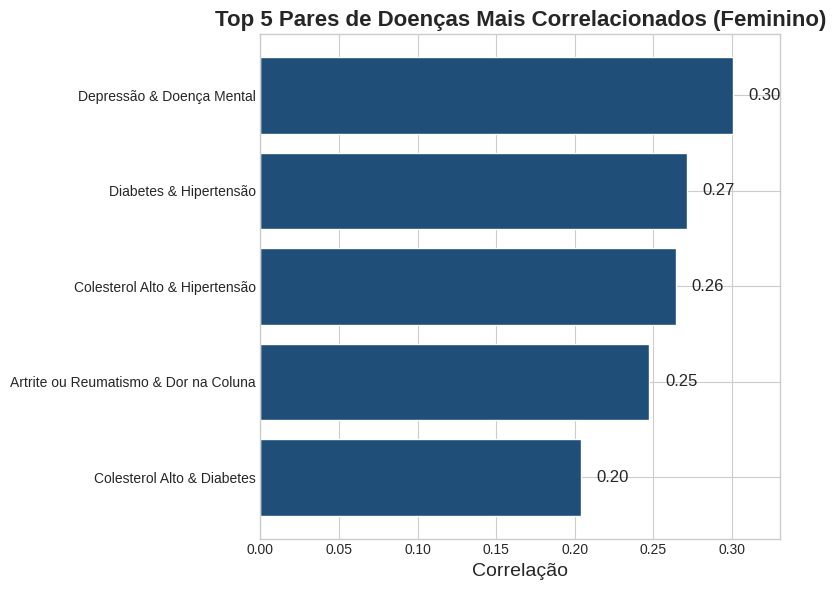

In [ ]:
print("\nGerando gráficos de top correlações do sexo Feminino")

corr_fem = df_fem.corr()
grafico_top_correlacoes(corr_fem, "Feminino")


Gerando gráficos de top correlações do sexo Masculino


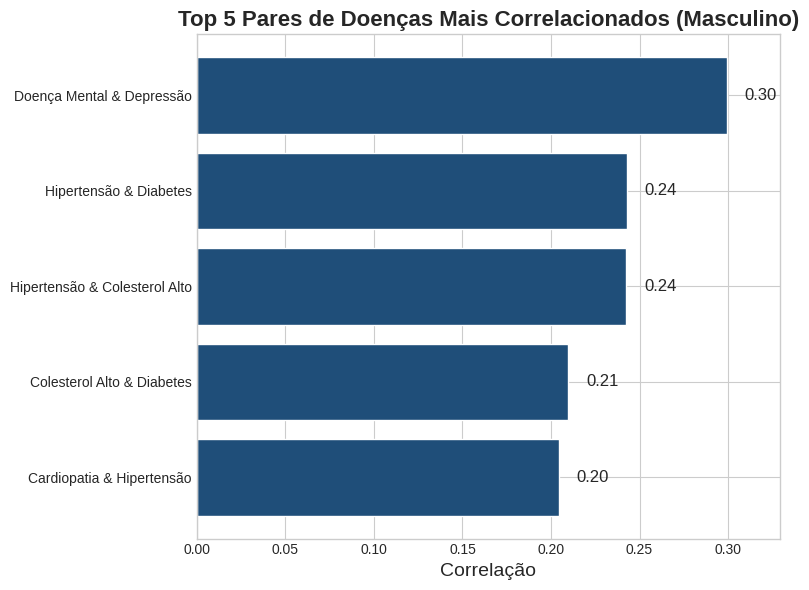

In [ ]:
print("\nGerando gráficos de top correlações do sexo Masculino")

corr_masc = df_masc.corr()
grafico_top_correlacoes(corr_masc, "Masculino")

### 4️⃣.3️⃣ Doenças Principais

Análise para encontrar padrões nas principais doenças

In [ ]:
ocorrencias = df[colunas_doencas].sum().sort_values(ascending=False)

tabela_ocorrencias = ocorrencias.head(10).to_frame(name='Número Total de Casos')

tabela_estilizada = tabela_ocorrencias.style \
    .format({
        'Número Total de Casos': '{:,}' # Formata o número com separador de milhar (ex: 1,234)
    }) \
    .set_caption("Top 10 Condições Mais Recorrentes (População Geral)") \
    .set_table_styles([
        # Estilo do título (caption)
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '14pt'),
            ('font-weight', 'bold'),
            ('color', '#f2f2f2'),
            ('margin-bottom', '10px')
        ]},
        # Estilo do cabeçalho da coluna
        {'selector': 'th.col_heading', 'props': [
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('background-color', '#000000')
        ]},
        # Estilo do índice (nomes das doenças)
        {'selector': 'th.row_heading', 'props': [
            ('text-align', 'left'),
            ('font-weight', 'bold')
        ]},
        # Estilo das células de dados
        {'selector': 'td', 'props': [
            ('text-align', 'center'),
            ('border', '1px solid #eee')
        ]}
    ])

display(tabela_estilizada)

,Número Total de Casos
Exercício Físico,"34,686"
Peso Normal,"33,789"
Sobrepeso,"32,422"
Álcool,"23,997"
Hipertensão,"23,719"
Dor na Coluna,"18,930"
Obesidade,"18,026"
Colesterol Alto,"13,349"
Tabaco,"11,224"
Depressão,"8,180"


In [ ]:
regras_gerais = pd.concat([regras_fem_novo, regras_masc_novo], ignore_index=True)

G_geral = nx.DiGraph()
for _, row in regras_gerais[regras_gerais['lift'] > 1.5].iterrows():
    antecedentes = row['antecedente'].split(', ')
    consequentes = row['consequente'].split(', ')
    for ant in antecedentes:
        for con in consequentes:
            if ant != con:
                G_geral.add_edge(ant, con, weight=row['lift'])

centralidade = nx.degree_centrality(G_geral)
df_centralidade = pd.Series(centralidade).sort_values(ascending=False)

tabela_centralidade = df_centralidade.head(10).to_frame(name='Grau de Centralidade')

tabela_estilizada = tabela_centralidade.style \
    .format({
        'Grau de Centralidade': '{:.3f}'
    }) \
    .set_caption("Top 10 Doenças Mais Centrais (Hubs da Rede)") \
    .set_table_styles([
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '14pt'),
            ('font-weight', 'bold'),
            ('color', '#000000'),
            ('margin-bottom', '10px')
        ]},
        {'selector': 'th.col_heading', 'props': [
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('background-color', '#000000')
        ]},
        {'selector': 'th.row_heading', 'props': [
            ('text-align', 'left'),
            ('font-weight', 'bold')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'center'),
            ('border', '1px solid #eee')
        ]}
    ])

print("\n--- Análise de Centralidade: Doenças 'Hub' na Rede de Comorbidades ---")
display(tabela_estilizada)


--- Análise de Centralidade: Doenças 'Hub' na Rede de Comorbidades ---


,Grau de Centralidade
Colesterol Alto,1.308
Dor na Coluna,1.308
Hipertensão,1.231
Artrite ou Reumatismo,1.000
Obesidade,1.000
Depressão,1.000
Diabetes,0.846
Sobrepeso,0.692
Peso Normal,0.538
Álcool,0.538


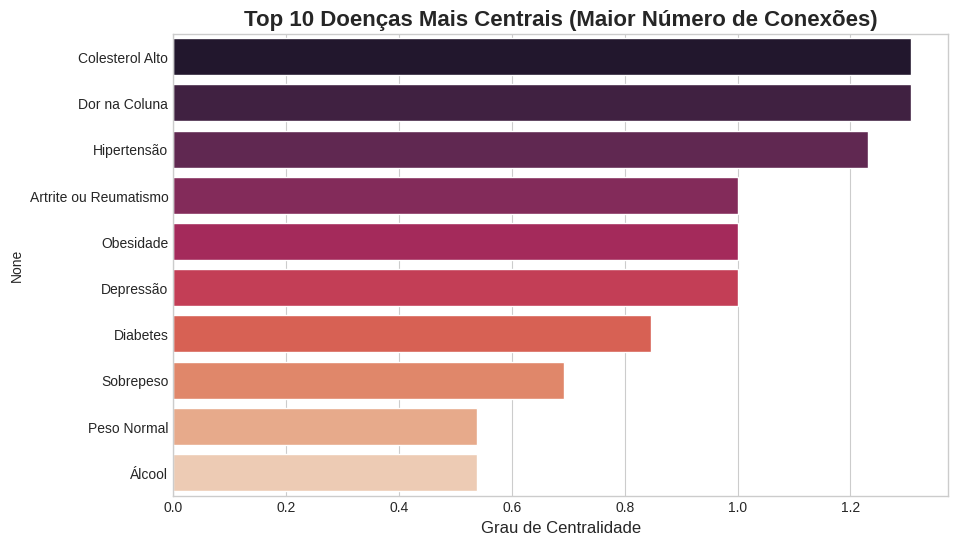

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df_centralidade.head(10).values, y=df_centralidade.head(10).index, palette='rocket', hue=df_centralidade.head(10).index, legend=False)
plt.title("Top 10 Doenças Mais Centrais (Maior Número de Conexões)", fontsize=16, fontweight='bold')
plt.xlabel("Grau de Centralidade", fontsize=12)
plt.show()

In [ ]:
def analise_significancia_genero(df, colunas):
    resultados = []
    for doenca in colunas:
        tabela_contingencia = pd.crosstab(df['Mulher'], df[doenca])

        if tabela_contingencia.shape[1] < 2:
            continue

        chi2, p_valor, _, _ = chi2_contingency(tabela_contingencia)

        prev_f = prev_fem.get(doenca, 0)
        prev_m = prev_masc.get(doenca, 0)

        resultados.append({
            'Condição': doenca,
            'Prevalência Feminino': f"{prev_f:.1%}",
            'Prevalência Masculino': f"{prev_m:.1%}",
            'p-valor': p_valor
        })

    df_resultados = pd.DataFrame(resultados)
    df_resultados['Significativo (p<0.05)'] = df_resultados['p-valor'] < 0.05
    return df_resultados.sort_values(by='p-valor')

print("\n--- Análise de Significância das Diferenças por Gênero ---")
tabela_significancia = analise_significancia_genero(df, colunas_doencas)

def colore_significativo(val):
    color = '#2ca02c' if val else '#d62728'
    return f'color: {color}; font-weight: bold'

tabela_estilizada = tabela_significancia.style \
    .format({
        'p-valor': '{:.2e}'
    }) \
    .map(colore_significativo, subset=['Significativo (p<0.05)']) \
    .set_caption("Análise de Significância das Diferenças por Gênero") \
    .set_table_styles([
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '14pt'),
            ('font-weight', 'bold'),
            ('color', '#333'),
            ('margin-bottom', '10px')
        ]},
        {'selector': 'th.col_heading', 'props': [
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('background-color', '#000000')
        ]},
        {'selector': 'td:first-child', 'props': [
            ('text-align', 'left'),
            ('font-weight', 'bold')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'center'),
            ('border', '1px solid #eee')
        ]}
    ]) \
    .hide(axis='index')

display(tabela_estilizada)


--- Análise de Significância das Diferenças por Gênero ---


Condição,Prevalência Feminino,Prevalência Masculino,p-valor,Significativo (p<0.05)
Artrite ou Reumatismo,11.9%,4.1%,0.00e+00,True
Depressão,13.6%,4.6%,0.00e+00,True
Álcool,18.0%,37.7%,0.00e+00,True
Colesterol Alto,19.0%,11.1%,1.60e-228,True
Tabaco,9.6%,16.3%,3.59e-196,True
Hipertensão,31.2%,22.5%,1.92e-182,True
Doença Mental,7.4%,3.3%,4.08e-155,True
Dor na Coluna,23.9%,19.1%,3.51e-66,True
Sobrepeso,34.3%,39.9%,5.86e-66,True
Obesidade,22.5%,18.4%,1.09e-52,True


## 5️⃣ Hipertensão

Aqui exploramos em detalhe a relação da **Hipertensão** com outras doenças.

In [ ]:
print("--- Maiores Correlações com Hipertensão (Feminino) ---")

corr_hipertensao_fem = corr_fem['Hipertensão'].sort_values(ascending=False).drop('Hipertensão').head(5)

tabela_corr_fem = corr_hipertensao_fem.to_frame(name='Coeficiente de Correlação')

tabela_estilizada = tabela_corr_fem.style \
    .format({'Coeficiente de Correlação': '{:.3f}'}) \
    .set_caption("Top 5 Maiores Correlações com Hipertensão (Feminino)") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold'), ('color', '#f2f2f2')]},
        {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#000000')]},
        {'selector': 'th.row_heading', 'props': [('text-align', 'left')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid #eee')]}
    ])

display(tabela_estilizada)

--- Maiores Correlações com Hipertensão (Feminino) ---


,Coeficiente de Correlação
Diabetes,0.271
Colesterol Alto,0.264
Artrite ou Reumatismo,0.200
Cardiopatia,0.192
Obesidade,0.168


In [ ]:
print("\n--- Maiores Correlações com Hipertensão (Masculino) ---")

corr_hipertensao_masc = corr_masc['Hipertensão'].sort_values(ascending=False).drop('Hipertensão').head(5)

tabela_corr_masc = corr_hipertensao_masc.to_frame(name='Coeficiente de Correlação')

tabela_estilizada = tabela_corr_masc.style \
    .format({'Coeficiente de Correlação': '{:.3f}'}) \
    .set_caption("Top 5 Maiores Correlações com Hipertensão (Masculino)") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold'), ('color', '#f2f2f2')]},
        {'selector': 'th.col_heading', 'props': [('text-align', 'center'), ('background-color', '#000000')]},
        {'selector': 'th.row_heading', 'props': [('text-align', 'left')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid #eee')]}
    ])

display(tabela_estilizada)


--- Maiores Correlações com Hipertensão (Masculino) ---


,Coeficiente de Correlação
Diabetes,0.243
Colesterol Alto,0.243
Cardiopatia,0.204
AVC ou Derrame,0.154
Obesidade,0.145


In [ ]:
print("\n--- Padrões de Associação para Hipertensão (Feminino) ---")
print("\nDoenças/condições que frequentemente levam à Hipertensão:")

regras_levam_a_ht_fem = regras_fem_novo[regras_fem_novo['consequente'].str.contains('Hipertensão')].head(5)

tabela_estilizada = regras_levam_a_ht_fem.style \
    .format({'suporte': '{:.2%}', 'confianca': '{:.2%}', 'lift': '{:.2f}'}) \
    .set_caption("Regras que Levam à Hipertensão (Feminino)") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold'), ('color', '#f2f2f2')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#000000')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid #eee')]},
        {'selector': 'td:first-child, td:nth-child(2)', 'props': [('text-align', 'left')]}
    ]).hide(axis='index')

display(tabela_estilizada)


--- Padrões de Associação para Hipertensão (Feminino) ---

Doenças/condições que frequentemente levam à Hipertensão:


antecedente,consequente,suporte,confianca,lift
Diabetes,"Hipertensão, Colesterol Alto",3.31%,34.26%,3.20
Artrite ou Reumatismo,"Hipertensão, Dor na Coluna",3.72%,31.16%,2.98
Diabetes,"Obesidade, Hipertensão",2.54%,26.25%,2.55
"Colesterol Alto, Diabetes",Hipertensão,3.31%,78.99%,2.53
Artrite ou Reumatismo,"Hipertensão, Colesterol Alto",3.24%,27.12%,2.53


In [ ]:
print("\nDoenças/condições frequentemente encontradas em pacientes com Hipertensão:")

regras_apos_ht_fem = regras_fem_novo[regras_fem_novo['antecedente'].str.contains('Hipertensão')].head(5)

tabela_estilizada = regras_apos_ht_fem.style \
    .format({'suporte': '{:.2%}', 'confianca': '{:.2%}', 'lift': '{:.2f}'}) \
    .set_caption("Condições Associadas à Hipertensão (Feminino)") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold'), ('color', '#f2f2f2')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#000000')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid #eee')]},
        {'selector': 'td:first-child, td:nth-child(2)', 'props': [('text-align', 'left')]}
    ]).hide(axis='index')

display(tabela_estilizada)


Doenças/condições frequentemente encontradas em pacientes com Hipertensão:


antecedente,consequente,suporte,confianca,lift
"Hipertensão, Colesterol Alto",Diabetes,3.31%,30.92%,3.20
"Hipertensão, Dor na Coluna",Artrite ou Reumatismo,3.72%,35.57%,2.98
"Hipertensão, Diabetes",Colesterol Alto,3.31%,49.24%,2.60
"Obesidade, Hipertensão",Diabetes,2.54%,24.68%,2.55
"Artrite ou Reumatismo, Hipertensão",Colesterol Alto,3.24%,48.17%,2.54


In [ ]:
print("\n\n--- Padrões de Associação para Hipertensão (Masculino) ---")
print("\nDoenças/condições que frequentemente levam à Hipertensão:")

regras_levam_a_ht_masc = regras_masc_novo[regras_masc_novo['consequente'].str.contains('Hipertensão')].head(5)

tabela_estilizada = regras_levam_a_ht_masc.style \
    .format({'suporte': '{:.2%}', 'confianca': '{:.2%}', 'lift': '{:.2f}'}) \
    .set_caption("Regras que Levam à Hipertensão (Masculino)") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold'), ('color', '#f2f2f2')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#000000')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid #eee')]},
        {'selector': 'td:first-child, td:nth-child(2)', 'props': [('text-align', 'left')]}
    ]).hide(axis='index')

display(tabela_estilizada)



--- Padrões de Associação para Hipertensão (Masculino) ---

Doenças/condições que frequentemente levam à Hipertensão:


antecedente,consequente,suporte,confianca,lift
Cardiopatia,Hipertensão,2.95%,60.10%,2.67
Diabetes,Hipertensão,4.13%,59.76%,2.66
Colesterol Alto,Hipertensão,5.68%,51.17%,2.27
Colesterol Alto,"Sobrepeso, Hipertensão",2.40%,21.56%,2.26
"Sobrepeso, Colesterol Alto",Hipertensão,2.40%,48.19%,2.14


In [ ]:
print("\nDoenças/condições frequentemente encontradas em pacientes com Hipertensão:")

regras_apos_ht_masc = regras_masc_novo[regras_masc_novo['antecedente'].str.contains('Hipertensão')].head(5)

tabela_estilizada = regras_apos_ht_masc.style \
    .format({'suporte': '{:.2%}', 'confianca': '{:.2%}', 'lift': '{:.2f}'}) \
    .set_caption("Condições Associadas à Hipertensão (Masculino)") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold'), ('color', '#f2f2f2')]},
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#000000')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid #eee')]},
        {'selector': 'td:first-child, td:nth-child(2)', 'props': [('text-align', 'left')]}
    ]).hide(axis='index')

display(tabela_estilizada)


Doenças/condições frequentemente encontradas em pacientes com Hipertensão:


antecedente,consequente,suporte,confianca,lift
"Exercício Físico, Hipertensão",Colesterol Alto,2.10%,26.55%,2.39
Hipertensão,Colesterol Alto,5.68%,25.25%,2.27
"Sobrepeso, Hipertensão",Colesterol Alto,2.40%,25.14%,2.26
"Álcool, Hipertensão",Obesidade,2.53%,34.09%,1.86
"Exercício Físico, Hipertensão",Obesidade,2.39%,30.26%,1.65


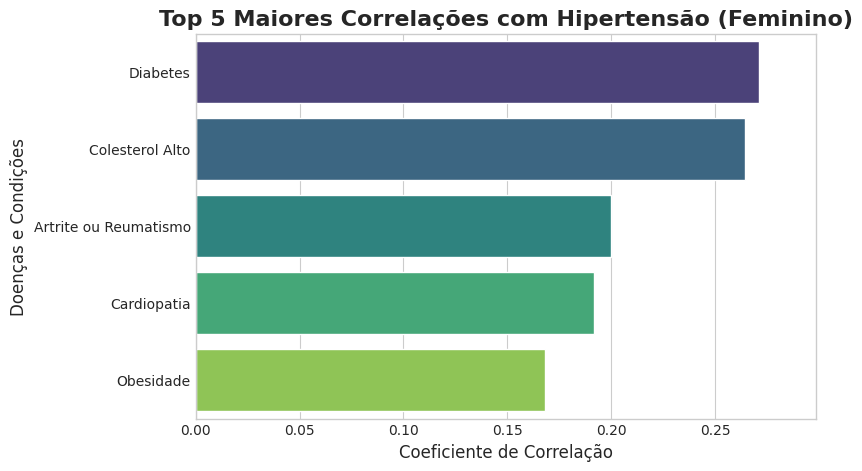

In [ ]:
sns.set_style("whitegrid")

corr_hipertensao_fem = corr_fem['Hipertensão'].sort_values(ascending=False).drop('Hipertensão').head(5)

corr_df_fem = corr_hipertensao_fem.reset_index()
corr_df_fem.columns = ['Doença', 'Correlação']

plt.figure(figsize=(8, 5))
sns.barplot(
    data=corr_df_fem,
    x='Correlação',
    y='Doença',
    palette='viridis',
    hue='Doença',
    legend=False
)

plt.title('Top 5 Maiores Correlações com Hipertensão (Feminino)', fontsize=16, fontweight='bold')
plt.xlabel('Coeficiente de Correlação', fontsize=12)
plt.ylabel('Doenças e Condições', fontsize=12)
plt.xlim(0, max(corr_df_fem['Correlação']) * 1.1)
plt.show()

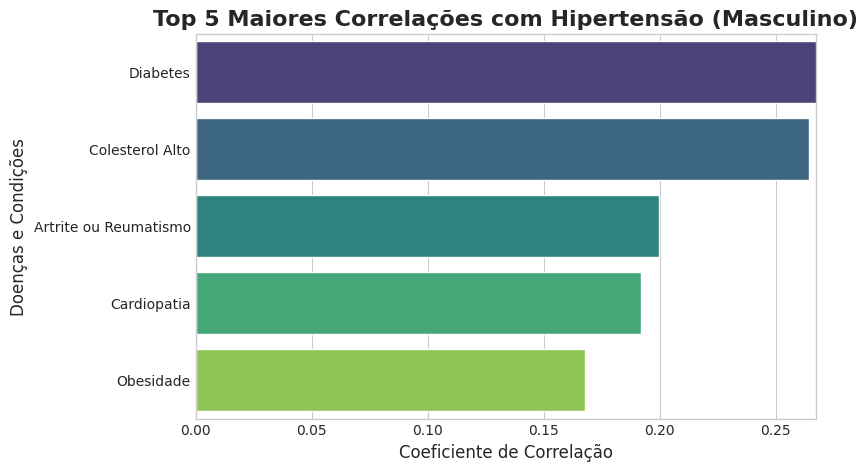

In [ ]:
corr_hipertensao_masc = corr_masc['Hipertensão'].sort_values(ascending=False).drop('Hipertensão').head(5)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=corr_df_fem,
    x='Correlação',
    y='Doença',
    palette='viridis',
    hue='Doença',
    legend=False
)

plt.title('Top 5 Maiores Correlações com Hipertensão (Masculino)', fontsize=16, fontweight='bold')
plt.xlabel('Coeficiente de Correlação', fontsize=12)
plt.ylabel('Doenças e Condições', fontsize=12)
plt.xlim(0, max(corr_hipertensao_masc.values) * 1.1)
plt.show()

### 5.1 Hipertensão e suas principais Ligações

In [ ]:
def plotar_grafo_focado(regras, doenca_foco, titulo):

    regras_foco = regras[
        regras['antecedente'].str.contains(doenca_foco) |
        regras['consequente'].str.contains(doenca_foco)
    ].nlargest(15, 'lift')

    G = nx.DiGraph()
    for _, row in regras_foco.iterrows():
        G.add_edge(row['antecedente'], row['consequente'], weight=row['lift'])

    node_colors = ['red' if node == doenca_foco else 'skyblue' for node in G.nodes()]
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    edge_widths = [d['weight'] for (u, v, d) in G.edges(data=True)]

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors,
            font_size=10, font_weight='bold', width=edge_widths,
            edge_color='gray', arrowsize=20)
    plt.title(titulo, fontsize=20, fontweight='bold')
    plt.show()

Visualização da Rede de Associações Centrada na Hipertensão Genero Feminino


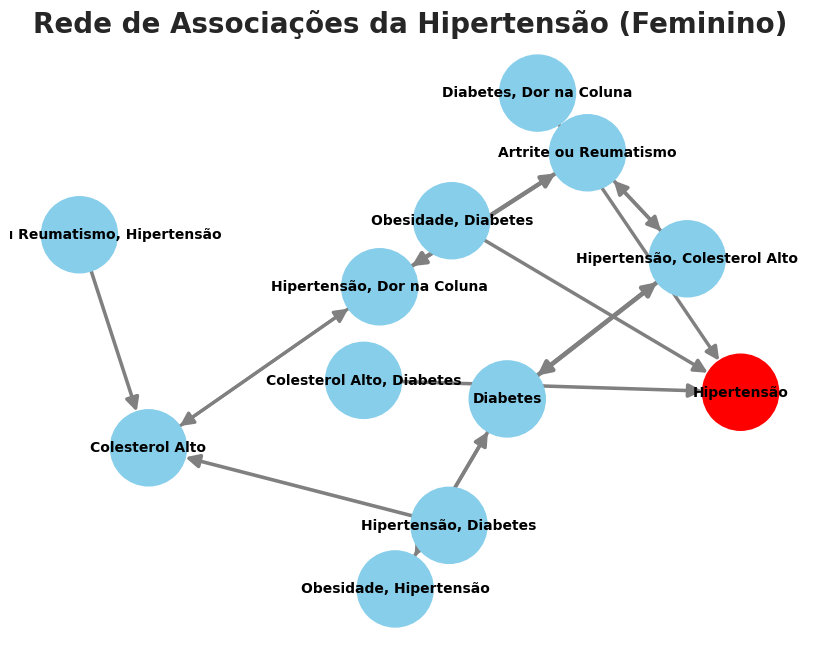

In [ ]:
print("Visualização da Rede de Associações Centrada na Hipertensão Genero Feminino")

plotar_grafo_focado(regras_fem_novo, 'Hipertensão', 'Rede de Associações da Hipertensão (Feminino)')

Visualização da Rede de Associações Centrada na Hipertensão Genero Masculino


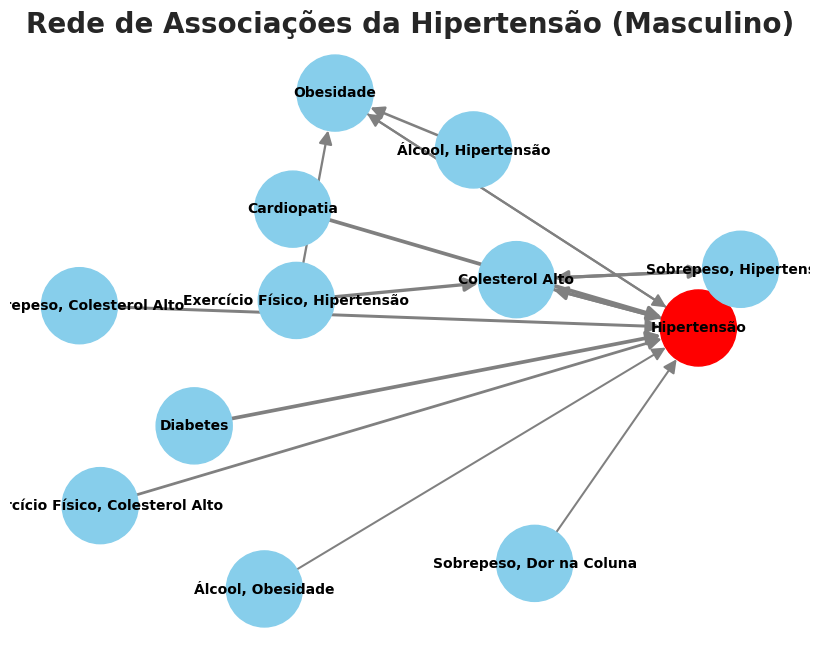

In [ ]:
print("Visualização da Rede de Associações Centrada na Hipertensão Genero Masculino")

plotar_grafo_focado(regras_masc_novo, 'Hipertensão', 'Rede de Associações da Hipertensão (Masculino)')

### 5.2 Hipertensão e IMC

In [ ]:
def plotar_impacto_imc_na_ht(regras, titulo):
    regras_imc_ht = regras[
        regras['antecedente'].isin(['Baixo Peso', 'Peso Normal', 'Sobrepeso', 'Obesidade']) &
        regras['consequente'].str.contains('Hipertensão')
    ].sort_values('confianca', ascending=False)

    if regras_imc_ht.empty:
        print(f"Nenhuma regra direta de IMC -> Hipertensão encontrada para o grupo: {titulo}")
        return

    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=regras_imc_ht,
        x='antecedente',
        y='confianca',
        palette='Reds_r',
        hue='antecedente',
        legend=False
    )
    plt.title(titulo, fontsize=16, fontweight='bold')
    plt.xlabel('Categoria de IMC', fontsize=12)
    plt.ylabel('Confiança (Probabilidade de ter Hipertensão)', fontsize=12)
    plt.ylim(0, 1.0)
    plt.show()

--- Gráfico de Impacto do IMC na Hipertensão (Feminino) ---


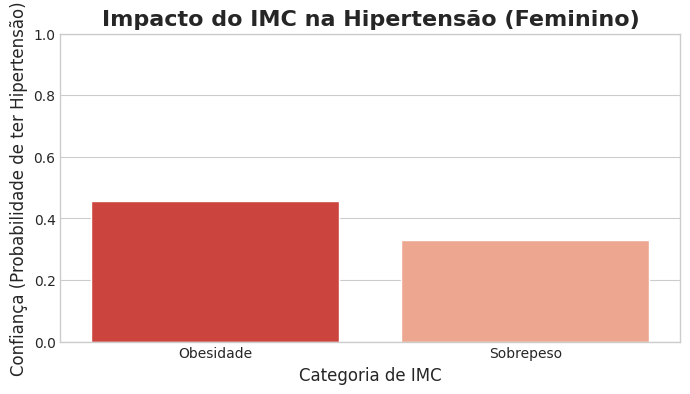

In [ ]:
print("--- Gráfico de Impacto do IMC na Hipertensão (Feminino) ---")
plotar_impacto_imc_na_ht(regras_fem_novo, 'Impacto do IMC na Hipertensão (Feminino)')


--- Gráfico de Impacto do IMC na Hipertensão (Masculino) ---


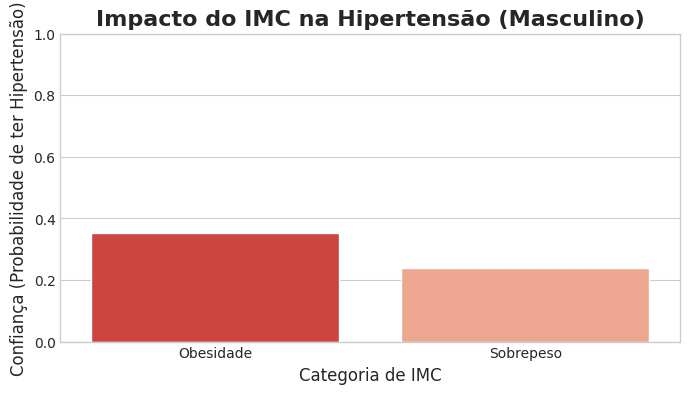

In [ ]:
print("\n--- Gráfico de Impacto do IMC na Hipertensão (Masculino) ---")
plotar_impacto_imc_na_ht(regras_masc_novo, 'Impacto do IMC na Hipertensão (Masculino)')

## 7️⃣ IMC e seus impactos

In [ ]:
def calcular_carga_doencas_por_imc(df):
    colunas_imc = ['Baixo Peso', 'Peso Normal', 'Sobrepeso', 'Obesidade']
    df_copia = df.copy()
    df_copia['IMC'] = df_copia[colunas_imc].idxmax(axis=1)

    colunas_apenas_doencas = [
        'Colesterol Alto', 'AVC ou Derrame', 'Asma', 'Artrite ou Reumatismo',
        'Dor na Coluna', 'DORT', 'Depressão', 'Hipertensão', 'Diabetes',
        'Cardiopatia', 'Câncer', 'Insuficiência Renal Crônica', 'Doença Mental',
        'Doença Crônica no Pulmão'
    ]

    df_copia['N_Doencas'] = df_copia[colunas_apenas_doencas].sum(axis=1)

    media_doencas_por_imc = df_copia.groupby('IMC')['N_Doencas'].mean().reindex(colunas_imc)

    return media_doencas_por_imc

def estilizar_tabela_carga_doencas(dados_imc, titulo):
    tabela_para_plotar = dados_imc.to_frame(name='Número Médio de Doenças')

    tabela_estilizada = tabela_para_plotar.style \
        .format({'Número Médio de Doenças': '{:.2f}'}) \
        .set_caption(titulo) \
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('caption-side', 'top'), ('font-size', '14pt'),
                ('font-weight', 'bold'), ('color', '#f2f2f2'), ('margin-bottom', '10px')
            ]},
            {'selector': 'th.col_heading', 'props': [
                ('text-align', 'center'), ('font-weight', 'bold'),
                ('background-color', '#000000')
            ]},
            {'selector': 'th.row_heading', 'props': [
                ('text-align', 'left'), ('font-weight', 'bold')
            ]},
            {'selector': 'td', 'props': [
                ('text-align', 'center'), ('border', '1px solid #eee')
            ]}
        ])

    display(tabela_estilizada)

def plotar_grafico_carga_doencas(dados_imc, titulo):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=dados_imc.index,
        y=dados_imc.values,
        palette='coolwarm',
        hue=dados_imc.index,
        legend=False
    )
    plt.title(titulo, fontsize=16, fontweight='bold')
    plt.xlabel('Categoria de IMC', fontsize=12)
    plt.ylabel('Número Médio de Comorbidades', fontsize=12)
    plt.show()

In [ ]:
print("Gerando análise do Gênero Feminino de doenças por IMC")

dados_fem_imc = calcular_carga_doencas_por_imc(df_fem)

titulo_tabela_fem = "Tabela: Carga de Doenças por IMC (Feminino)"
estilizar_tabela_carga_doencas(dados_fem_imc, titulo_tabela_fem)

Gerando análise do Gênero Feminino de doenças por IMC


,Número Médio de Doenças
IMC,
Baixo Peso,1.15
Peso Normal,1.12
Sobrepeso,1.44
Obesidade,1.81


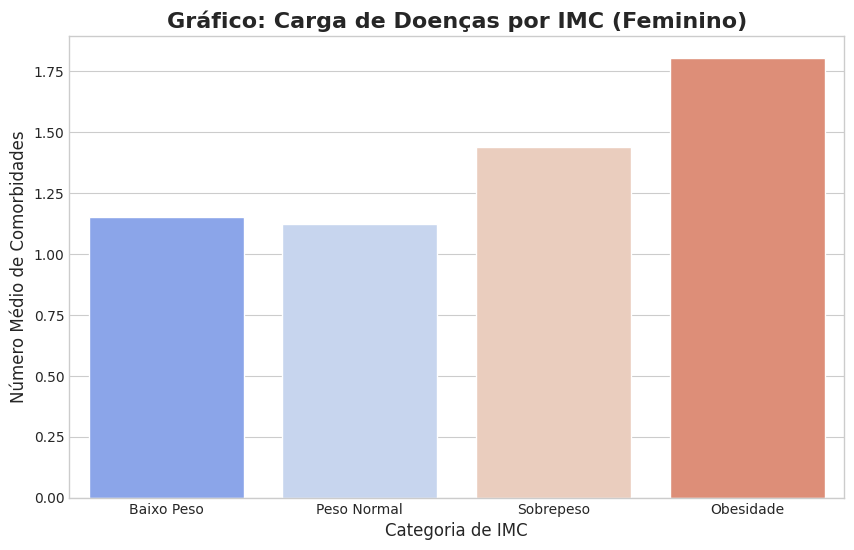

In [ ]:
titulo_grafico_fem = "Gráfico: Carga de Doenças por IMC (Feminino)"
plotar_grafico_carga_doencas(dados_fem_imc, titulo_grafico_fem)

In [ ]:
print("Gerando análise do Gênero Masculino de doenças por IMC")

dados_masc_imc = calcular_carga_doencas_por_imc(df_masc)

titulo_tabela_masc = "Tabela: Carga de Doenças por IMC (Masculino)"
estilizar_tabela_carga_doencas(dados_masc_imc, titulo_tabela_masc)

Gerando análise do Gênero Masculino de doenças por IMC


,Número Médio de Doenças
IMC,
Baixo Peso,0.84
Peso Normal,0.73
Sobrepeso,0.92
Obesidade,1.17


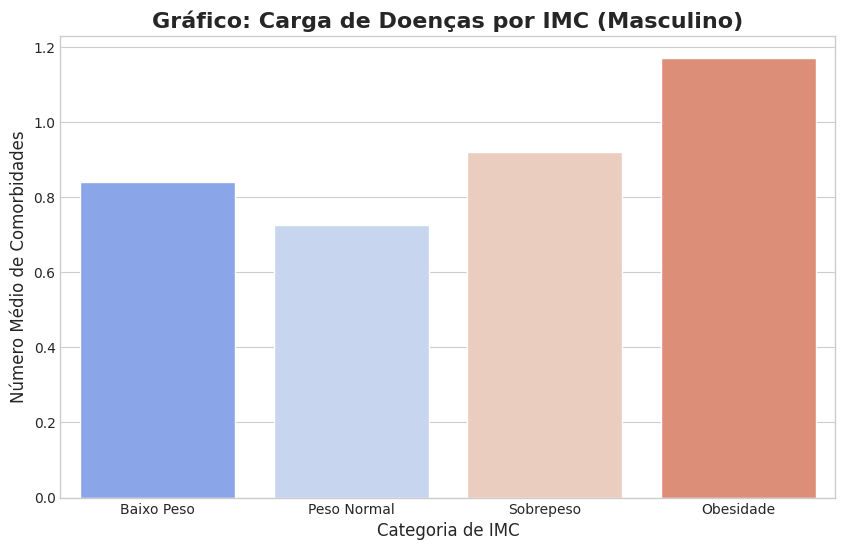

In [ ]:
titulo_grafico_masc = "Gráfico: Carga de Doenças por IMC (Masculino)"
plotar_grafico_carga_doencas(dados_masc_imc, titulo_grafico_masc)

### 7️⃣.1️⃣ Principais Doenças relacionadas ao IMC

In [ ]:
def analisar_consequencias_imc(regras, titulo, top_n=8):
    regras_imc = regras[
        regras['antecedente'].isin(['Sobrepeso', 'Obesidade', 'Baixo Peso'])
    ].copy()

    regras_imc = regras_imc[~regras_imc['consequente'].str.contains(',')].copy()

    if regras_imc.empty:
        print(f"Nenhuma regra com IMC como antecedente único encontrada para: {titulo}")
        return

    heatmap_data_completa = regras_imc.pivot_table(
        index='antecedente',
        columns='consequente',
        values='confianca'
    )

    if heatmap_data_completa.empty:
        print(f"Não foi possível gerar a tabela de calor para: {titulo}")
        return

    top_consequentes = heatmap_data_completa.sum().nlargest(top_n).index
    heatmap_data_filtrada = heatmap_data_completa[top_consequentes]

    print(f"\n--- {titulo} ---")
    print(f"Probabilidade (Confiança) das Top {top_n} Doenças, dado o IMC:")

    display(heatmap_data_filtrada.fillna(0).style.format("{:.2%}").background_gradient(cmap='YlOrBr'))
    print("-" * 50)

    plt.figure(figsize=(14, 5))
    sns.heatmap(
        heatmap_data_filtrada,
        annot=True,
        fmt=".2%",
        cmap="YlOrBr",
        linewidths=.5,
        linecolor='lightgray'
    )
    plt.title(titulo, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Doença Associada (Consequente)', fontsize=14)

    plt.ylabel('Categoria de IMC', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()

Gerando análise das Principais Doenças Associadas ao IMC Elevado do Gênero Feminino

--- Principais Doenças Associadas ao IMC (Feminino) ---
Probabilidade (Confiança) das Top 8 Doenças, dado o IMC:


consequente,Hipertensão,Dor na Coluna,Colesterol Alto,Exercício Físico
antecedente,,,,
Obesidade,45.59%,28.65%,23.42%,0.00%
Sobrepeso,32.89%,24.47%,20.75%,38.40%


--------------------------------------------------


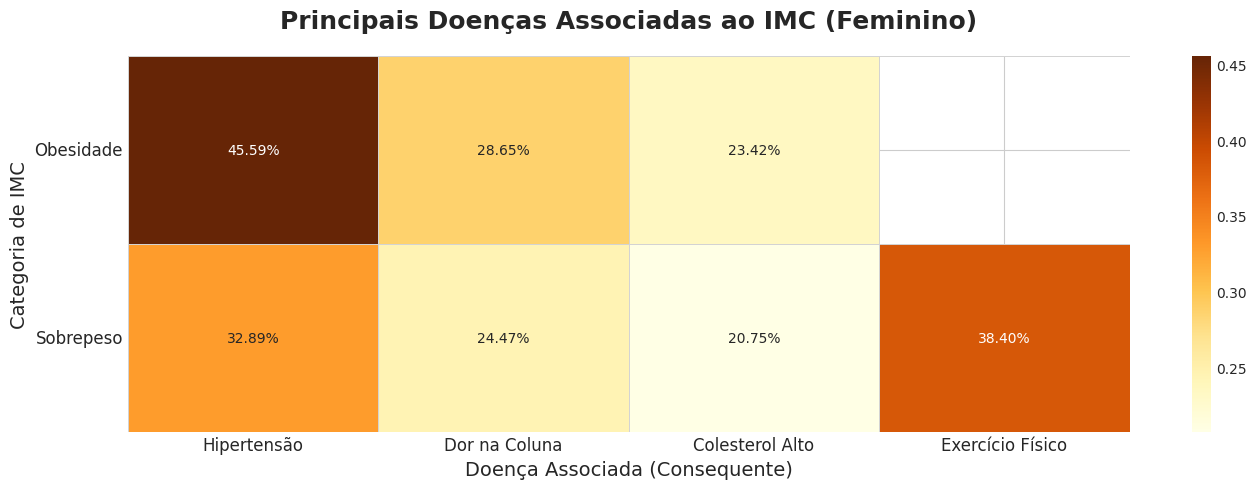

In [ ]:
print("Gerando análise das Principais Doenças Associadas ao IMC Elevado do Gênero Feminino")

titulo_analise_fem = "Principais Doenças Associadas ao IMC (Feminino)"

analisar_consequencias_imc(regras_fem_novo, titulo_analise_fem)


Gerando análise das Principais Doenças Associadas ao IMC Elevado do Gênero Masculino

--- Principais Doenças Associadas ao IMC (Masculino) ---
Probabilidade (Confiança) das Top 8 Doenças, dado o IMC:


consequente,Álcool,Hipertensão,Exercício Físico
antecedente,,,
Obesidade,42.41%,35.26%,0.00%
Sobrepeso,39.00%,23.87%,45.09%


--------------------------------------------------


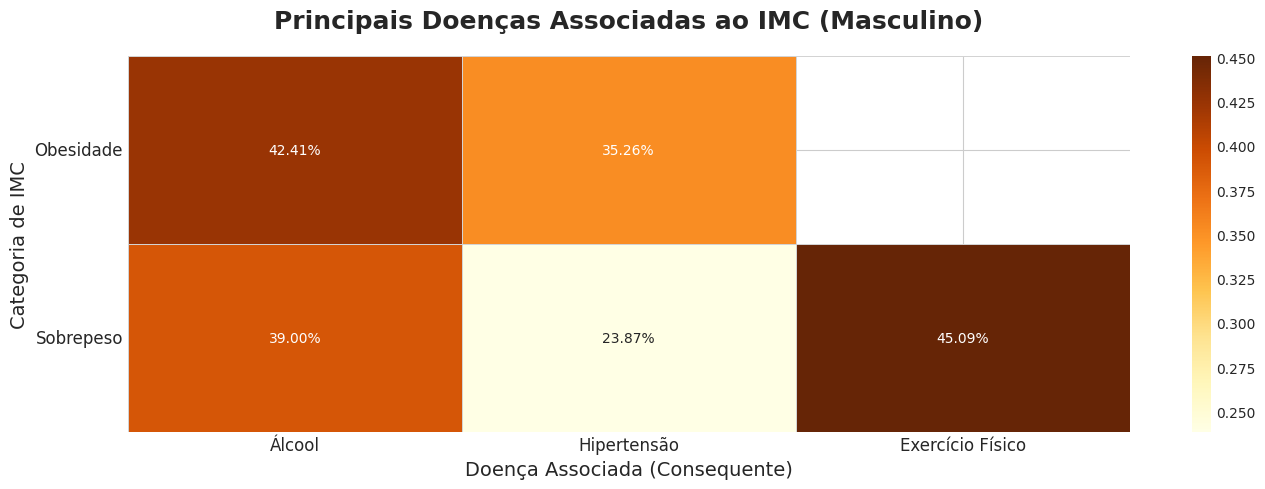

In [ ]:
print("\nGerando análise das Principais Doenças Associadas ao IMC Elevado do Gênero Masculino")

titulo_analise_masc = "Principais Doenças Associadas ao IMC (Masculino)"

analisar_consequencias_imc(regras_masc_novo, titulo_analise_masc)

### 7️⃣.2️⃣ Análise de Risco: O Impacto do IMC Elevado

In [ ]:
def calcular_risco_imc_elevado(df):
    df_copia = df.copy()
    df_copia['IMC Elevado'] = ((df_copia['Sobrepeso'] == 1) | (df_copia['Obesidade'] == 1)).astype(int)

    grupos_comparacao = df_copia[(df_copia['Peso Normal'] == 1) | (df_copia['IMC Elevado'] == 1)]

    prevalencia_por_grupo = grupos_comparacao.groupby('IMC Elevado').mean().drop(columns=['Peso Normal', 'Sobrepeso', 'Obesidade', 'Baixo Peso'])

    denominador = prevalencia_por_grupo.loc[0].replace(0, np.nan)
    numerador = prevalencia_por_grupo.loc[1]

    risco_relativo = (numerador / denominador).sort_values(ascending=False).dropna()

    return risco_relativo

def estilizar_tabela_risco_imc(dados_risco, sexo):
    titulo = f"Tabela: Risco por IMC Elevado ({sexo})"
    print(f"\n--- {titulo} ---")

    tabela_para_plotar = dados_risco.head(10).to_frame(name='Razão de Prevalência (x vezes)')

    tabela_estilizada = tabela_para_plotar.style \
        .format({'Razão de Prevalência (x vezes)': '{:.2f}x'}) \
        .set_caption(titulo) \
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('caption-side', 'top'), ('font-size', '14pt'),
                ('font-weight', 'bold'), ('color', '#f2f2f2'), ('margin-bottom', '10px')
            ]},
            {'selector': 'th.col_heading', 'props': [
                ('text-align', 'center'), ('font-weight', 'bold'),
                ('background-color', '#000000')
            ]},
            {'selector': 'th.row_heading', 'props': [('text-align', 'left'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [
                ('text-align', 'center'), ('border', '1px solid #eee')
            ]}
        ])

    display(tabela_estilizada)

def plotar_grafico_risco_imc(dados_risco, sexo):
    titulo = f'Top 10 Condições com Maior Aumento de Risco por IMC Elevado ({sexo})'
    dados_plot = dados_risco.head(10)

    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=dados_plot.index, y=dados_plot.values, palette='dark:tomato', hue=dados_plot.index, legend=False)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}x",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points',
                    fontsize=11, color='black', weight='bold')

    plt.title(titulo, fontsize=16, fontweight='bold')
    plt.ylabel('Razão de Prevalência (Vezes mais provável)', fontsize=12)
    plt.xlabel('Condição', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=1, color='gray', linestyle='--')
    plt.ylim(0, dados_plot.max() * 1.2)
    plt.show()

In [ ]:
print("Gerando análise de risco de IMC elevado no gênero Feminino")

risco_relativo_fem = calcular_risco_imc_elevado(df_fem)

estilizar_tabela_risco_imc(risco_relativo_fem, 'Feminino')

Gerando análise de risco de IMC elevado no gênero Feminino

--- Tabela: Risco por IMC Elevado (Feminino) ---


,Razão de Prevalência (x vezes)
Diabetes,1.78x
Hipertensão,1.72x
Artrite ou Reumatismo,1.49x
Colesterol Alto,1.42x
Insuficiência Renal Crônica,1.40x
DORT,1.34x
Cardiopatia,1.33x
AVC ou Derrame,1.32x
Dor na Coluna,1.25x
Depressão,1.25x


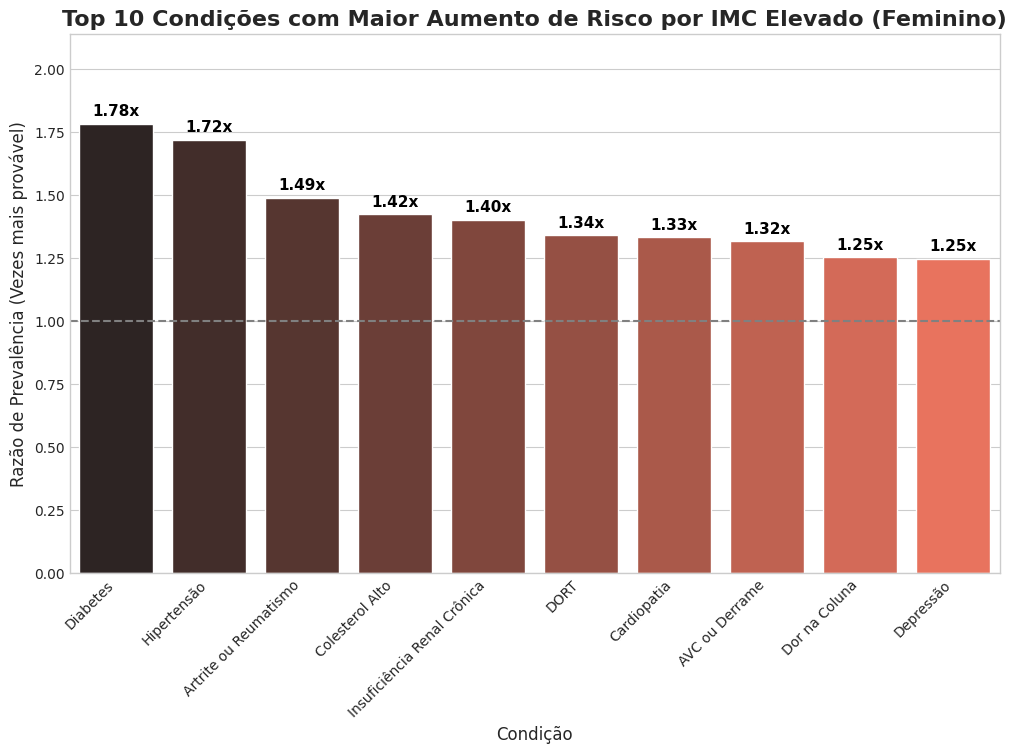

In [ ]:
plotar_grafico_risco_imc(risco_relativo_fem, 'Feminino')

In [ ]:
print("Gerando análise de risco de IMC elevado no gênero Masculino")

risco_relativo_masc = calcular_risco_imc_elevado(df_masc)

estilizar_tabela_risco_imc(risco_relativo_masc, 'Masculino')

Gerando análise de risco de IMC elevado no gênero Masculino

--- Tabela: Risco por IMC Elevado (Masculino) ---


,Razão de Prevalência (x vezes)
Colesterol Alto,1.92x
Hipertensão,1.80x
Diabetes,1.74x
DORT,1.40x
Depressão,1.30x
Artrite ou Reumatismo,1.26x
Doença Mental,1.23x
Cardiopatia,1.21x
Álcool,1.16x
Exercício Físico,1.09x


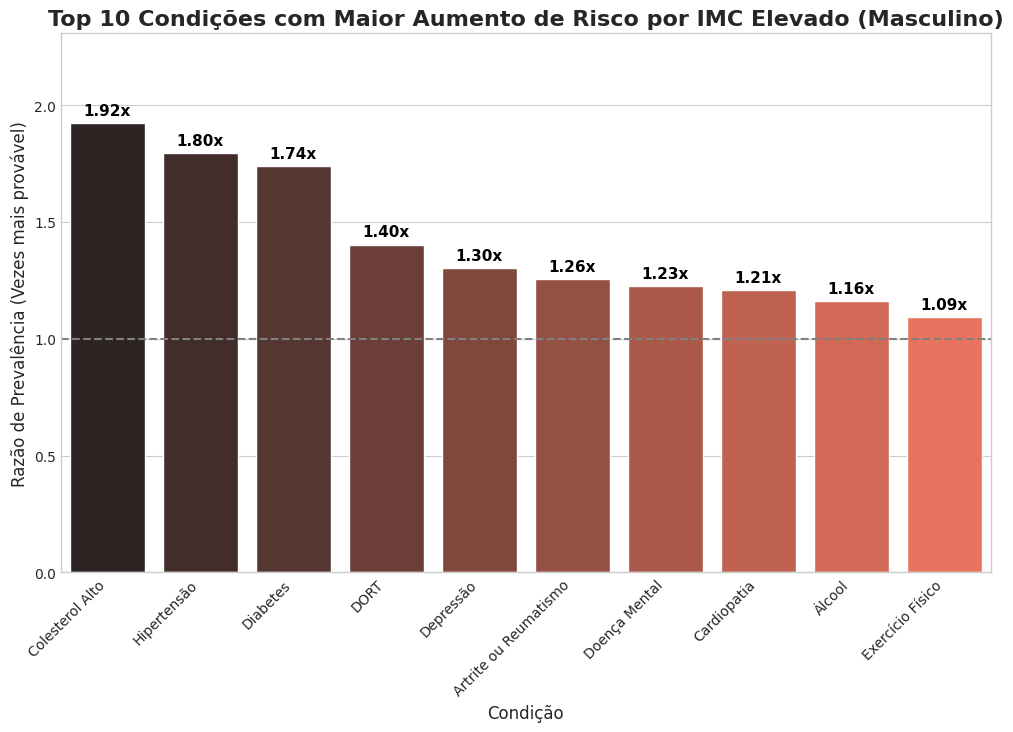

In [ ]:
plotar_grafico_risco_imc(risco_relativo_masc, 'Masculino')

## 8️⃣ Análise por Faixa Etária

Segmentamos os dados por faixas etárias para identificar padrões de prevalência de doenças em diferentes fases da vida.

In [ ]:
# 1. Definimos a lista com os nomes exatos das colunas de faixa etária
colunas_faixa_etaria = [
    'Idade 18 a 29', 'Idade 30 a 39', 'Idade 40 a 49', 'Idade 50 a 59',
    'Idade 60 a 69', 'Idade 70 a 79', 'Idade 80 a 89', 'Idade 90 a 99',
    'Idade 100 a 104'
]

colunas_doencas = [
    'Colesterol Alto', 'AVC ou Derrame', 'Asma', 'Artrite ou Reumatismo', 'Dor na Coluna',
    'DORT', 'Depressão', 'Hipertensão', 'Diabetes', 'Cardiopatia', 'Câncer',
    'Insuficiência Renal Crônica', 'Doença Mental', 'Doença Crônica no Pulmão'
]

# 2. Selecionamos apenas essas colunas do DataFrame e somamos os valores de cada uma.
# A soma de cada coluna nos dá a contagem de pessoas naquela faixa.
distribuicao_por_idade = df[colunas_faixa_etaria].sum()

# 3. Pegamos o resultado e aplicamos a mesma formatação que você já havia criado.
tabela_distribuicao = distribuicao_por_idade.to_frame(name='Quantidade de Pessoas')

tabela_estilizada = tabela_distribuicao.style \
    .format({
        'Quantidade de Pessoas': '{:,}'
    }) \
    .set_caption("Distribuição de Pessoas por Faixa Etária") \
    .set_table_styles([
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '14pt'),
            ('font-weight', 'bold'),
            ('color', '#f2f2f2'), # Cor do título ajustada para melhor leitura
            ('margin-bottom', '10px')
        ]},
        {'selector': 'th.col_heading', 'props': [
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('background-color', '#000000')
        ]},
        {'selector': 'th.row_heading', 'props': [
             ('text-align', 'left'),
             ('font-weight', 'bold')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'center'),
            ('border', '1px solid #ddd')
        ]}
    ])

print("\n--- Distribuição de Pessoas por Faixa Etária ---")
display(tabela_estilizada)


--- Distribuição de Pessoas por Faixa Etária ---


,Quantidade de Pessoas
Idade 18 a 29,"14,924"
Idade 30 a 39,"17,835"
Idade 40 a 49,"16,544"
Idade 50 a 59,"15,649"
Idade 60 a 69,"12,554"
Idade 70 a 79,"7,156"
Idade 80 a 89,"2,580"
Idade 90 a 99,413
Idade 100 a 104,22


### 8️⃣.1️⃣ Principais Doenças

In [ ]:
ocorrencias_totais = df[colunas_doencas].sum().sort_values(ascending=False)
top_doencas = ocorrencias_totais.head(5)

tabela_top_doencas = top_doencas.to_frame(name='Número Total de Casos')

tabela_estilizada = tabela_top_doencas.style \
    .format({'Número Total de Casos': '{:,}'}) \
    .set_caption("Top 5 Condições Mais Recorrentes na População Geral") \
    .set_table_styles([
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '14pt'),
            ('font-weight', 'bold'),
            ('color', '#f2f2f2'),
            ('margin-bottom', '10px')
        ]},
        {'selector': 'th.col_heading', 'props': [
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('background-color', '#000000')
        ]},
        {'selector': 'th.row_heading', 'props': [
            ('text-align', 'left'),
            ('font-weight', 'bold')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'center'),
            ('border', '1px solid #eee')
        ]}
    ])

display(tabela_estilizada)

lista_top_doencas = top_doencas.index.tolist()

,Número Total de Casos
Hipertensão,"23,719"
Dor na Coluna,"18,930"
Colesterol Alto,"13,349"
Depressão,"8,180"
Diabetes,"7,323"


### 8️⃣.2️⃣ Evolução da Prevalência das Doenças por Idade

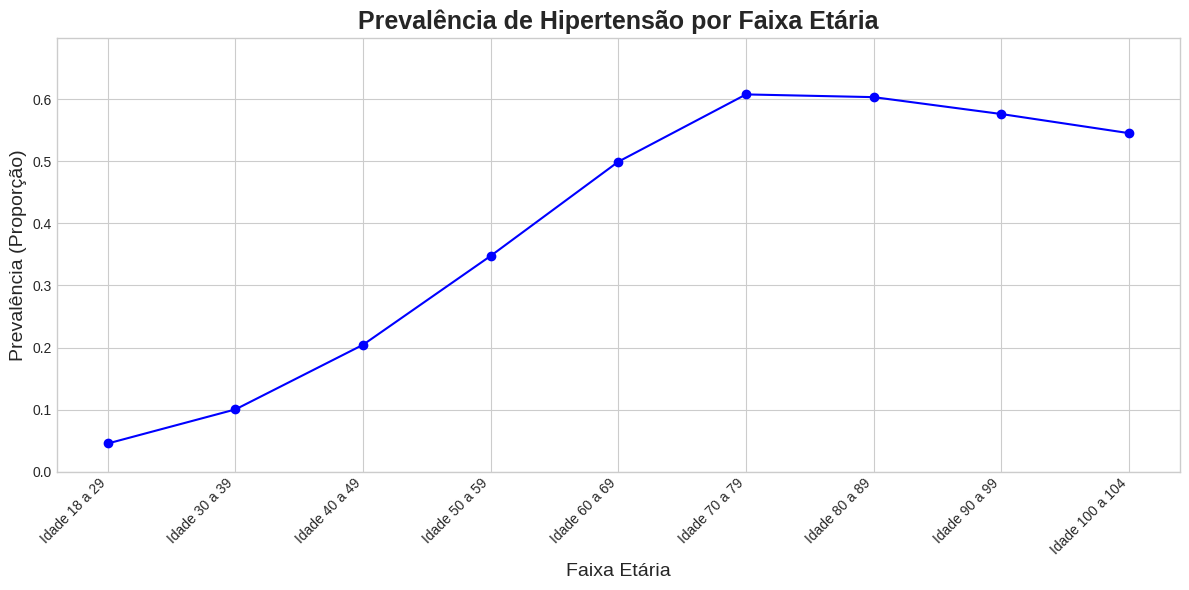

In [ ]:
prevalencias = {}

for faixa in colunas_faixa_etaria:

    grupo_da_faixa = df[df[faixa] == 1]

    prevalencias[faixa] = grupo_da_faixa[colunas_doencas].mean()

prevalencia_por_idade = pd.DataFrame(prevalencias).T

doenca_foco = 'Hipertensão'
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

plt.plot(prevalencia_por_idade.index, prevalencia_por_idade[doenca_foco], marker='o', linestyle='-', color='b')

plt.title(f'Prevalência de {doenca_foco} por Faixa Etária', fontsize=18, fontweight='bold')
plt.ylabel('Prevalência (Proporção)', fontsize=14)
plt.xlabel('Faixa Etária', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(prevalencia_por_idade[doenca_foco]) * 1.15)
plt.tight_layout()
plt.show()

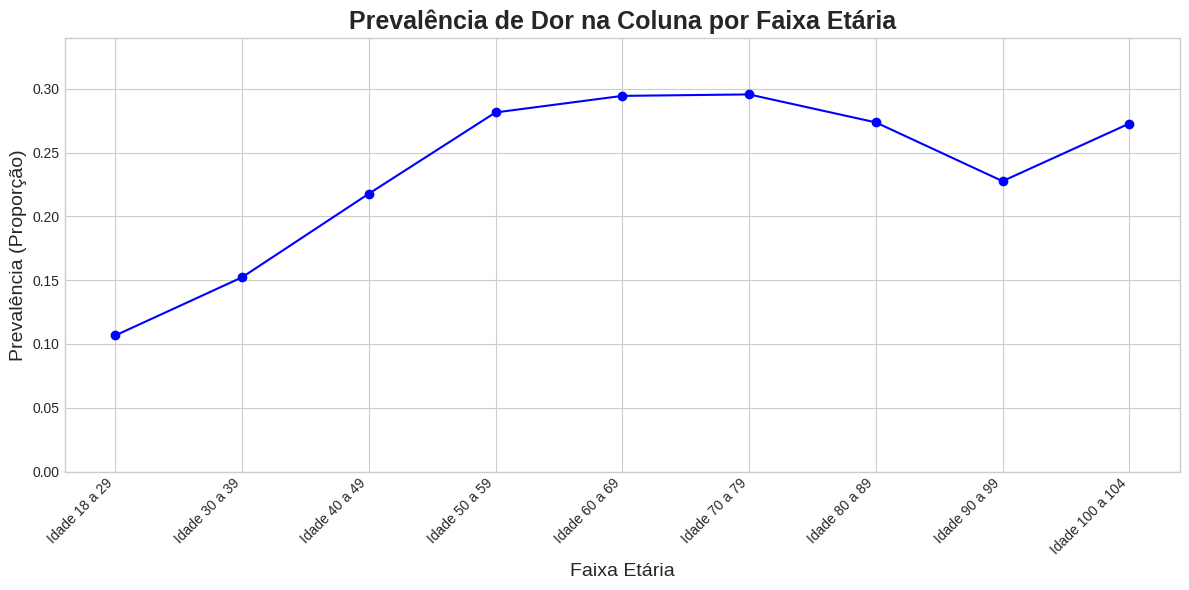

In [ ]:
doenca_foco = 'Dor na Coluna'
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

plt.plot(prevalencia_por_idade.index, prevalencia_por_idade[doenca_foco], marker='o', linestyle='-', color='b')

plt.title(f'Prevalência de {doenca_foco} por Faixa Etária', fontsize=18, fontweight='bold')
plt.ylabel('Prevalência (Proporção)', fontsize=14)
plt.xlabel('Faixa Etária', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(prevalencia_por_idade[doenca_foco]) * 1.15)
plt.tight_layout()
plt.show()

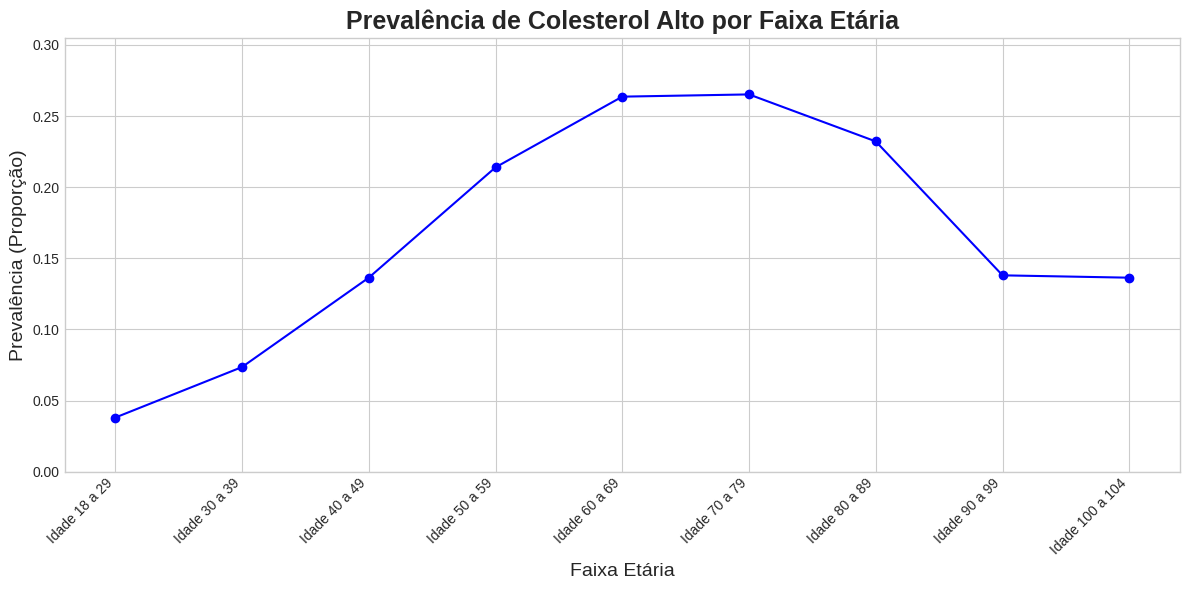

In [ ]:
doenca_foco = 'Colesterol Alto'
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

plt.plot(prevalencia_por_idade.index, prevalencia_por_idade[doenca_foco], marker='o', linestyle='-', color='b')

plt.title(f'Prevalência de {doenca_foco} por Faixa Etária', fontsize=18, fontweight='bold')
plt.ylabel('Prevalência (Proporção)', fontsize=14)
plt.xlabel('Faixa Etária', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(prevalencia_por_idade[doenca_foco]) * 1.15)
plt.tight_layout()
plt.show()

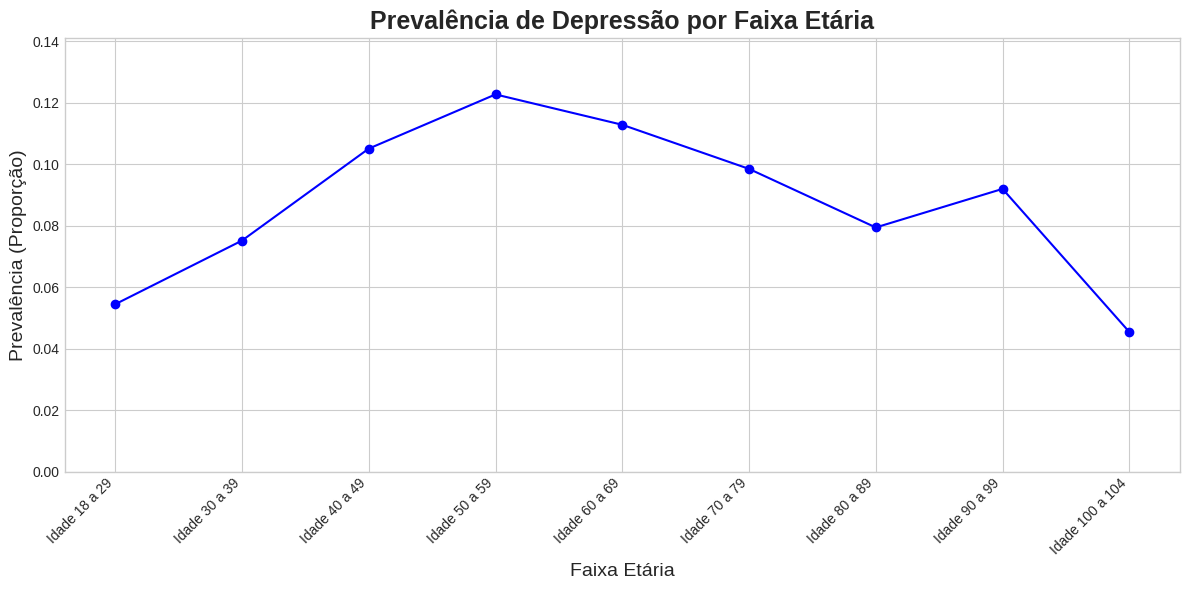

In [ ]:
doenca_foco = 'Depressão'
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

plt.plot(prevalencia_por_idade.index, prevalencia_por_idade[doenca_foco], marker='o', linestyle='-', color='b')

plt.title(f'Prevalência de {doenca_foco} por Faixa Etária', fontsize=18, fontweight='bold')
plt.ylabel('Prevalência (Proporção)', fontsize=14)
plt.xlabel('Faixa Etária', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(prevalencia_por_idade[doenca_foco]) * 1.15)
plt.tight_layout()
plt.show()

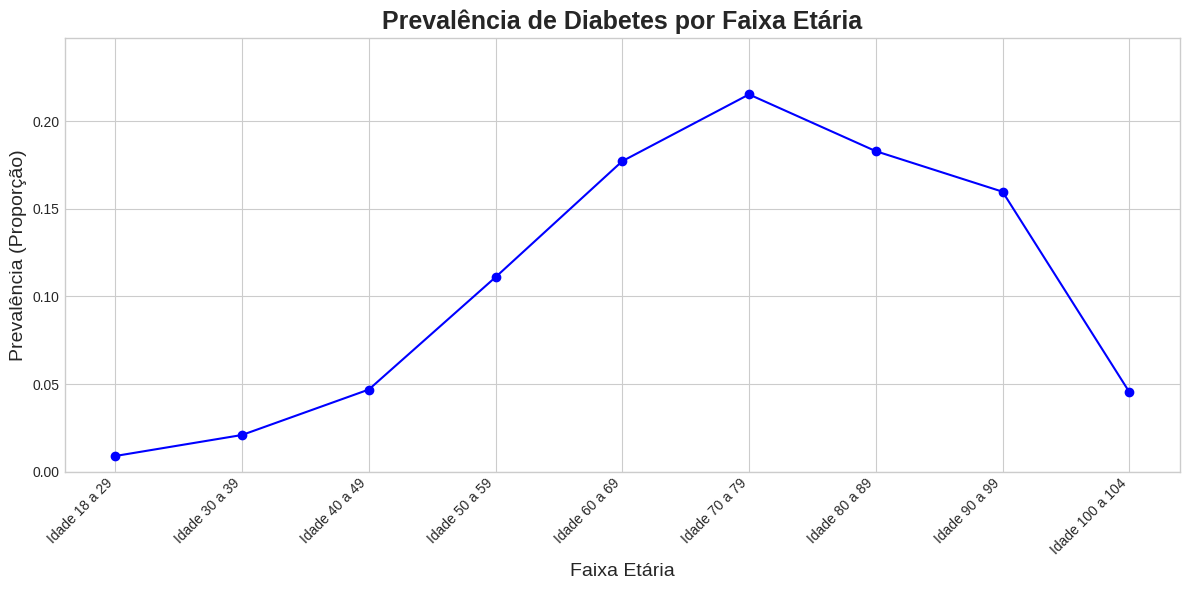

In [ ]:
doenca_foco = 'Diabetes'
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

plt.plot(prevalencia_por_idade.index, prevalencia_por_idade[doenca_foco], marker='o', linestyle='-', color='b')

plt.title(f'Prevalência de {doenca_foco} por Faixa Etária', fontsize=18, fontweight='bold')
plt.ylabel('Prevalência (Proporção)', fontsize=14)
plt.xlabel('Faixa Etária', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(prevalencia_por_idade[doenca_foco]) * 1.15)
plt.tight_layout()
plt.show()

### 8️⃣.3️⃣ Carga de Doenças por Faixa Etária

In [ ]:
df['N_Doencas'] = df[colunas_doencas].sum(axis=1)

medias = {}

for faixa in colunas_faixa_etaria:
    grupo_da_faixa = df[df[faixa] == 1]

    medias[faixa] = grupo_da_faixa['N_Doencas'].mean()

media_doencas_por_idade = pd.Series(medias)

tabela_media_doencas = media_doencas_por_idade.to_frame(name='Número Médio de Doenças')

tabela_estilizada = tabela_media_doencas.style \
    .format({
        'Número Médio de Doenças': '{:.2f}'
    }) \
    .set_caption("Carga Média de Comorbidades por Faixa Etária") \
    .set_table_styles([
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '14pt'),
            ('font-weight', 'bold'),
            ('color', '#f2f2f2'),
            ('margin-bottom', '10px')
        ]},
        {'selector': 'th.col_heading', 'props': [
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('background-color', '#000000')
        ]},
        {'selector': 'th.row_heading', 'props': [
            ('text-align', 'left'),
            ('font-weight', 'bold')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'center'),
            ('border', '1px solid #ddd')
        ]}
    ])

print("\n--- Número Médio de Doenças por Faixa Etária ---")
display(tabela_estilizada)


--- Número Médio de Doenças por Faixa Etária ---


,Número Médio de Doenças
Idade 18 a 29,0.42
Idade 30 a 39,0.62
Idade 40 a 49,0.98
Idade 50 a 59,1.47
Idade 60 a 69,1.86
Idade 70 a 79,2.09
Idade 80 a 89,2.05
Idade 90 a 99,1.94
Idade 100 a 104,1.86


### 8️⃣.4️⃣ Carga Média de Comorbidades por Faixa Etária

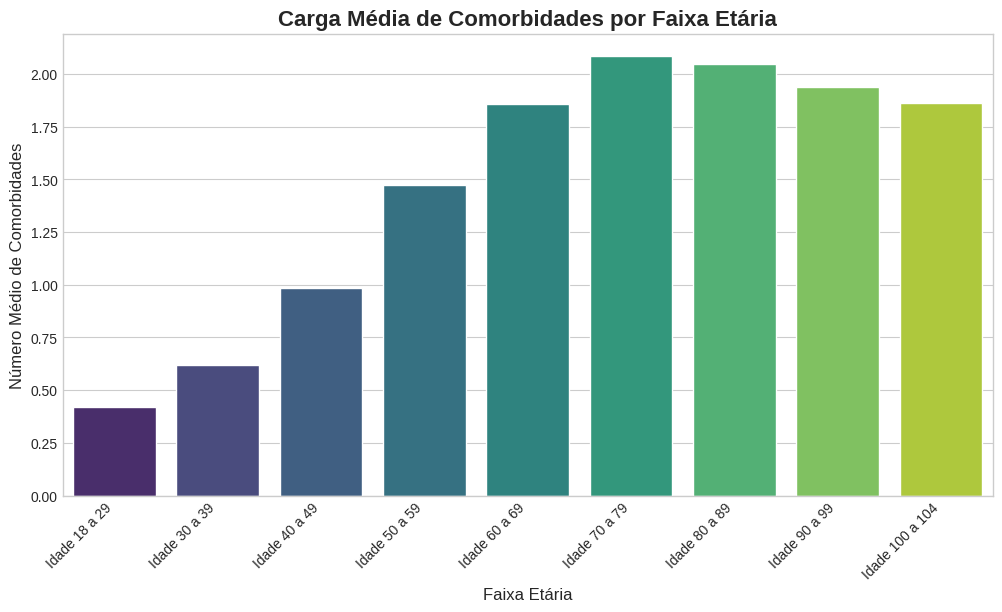

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=media_doencas_por_idade.index, y=media_doencas_por_idade.values, palette='viridis', hue=media_doencas_por_idade.index, legend=False)
plt.title('Carga Média de Comorbidades por Faixa Etária', fontsize=16, fontweight='bold')
plt.xlabel('Faixa Etária', fontsize=12)
plt.ylabel('Número Médio de Comorbidades', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

### 8️⃣.5️⃣ HeatMap de Prevalência por Idade

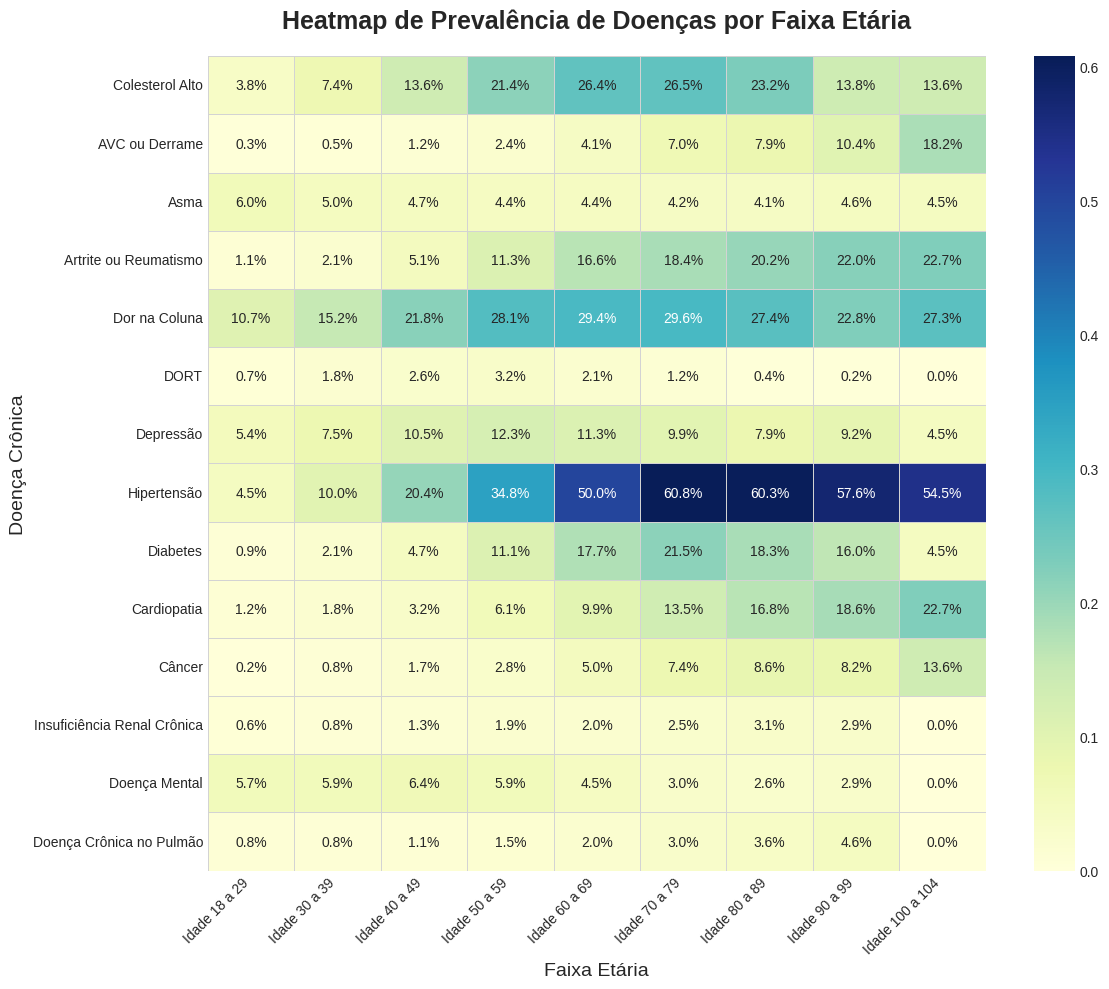

In [ ]:
prevalencias = {}
for faixa in colunas_faixa_etaria:
    grupo_da_faixa = df[df[faixa] == 1]
    prevalencias[faixa] = grupo_da_faixa[colunas_doencas].mean()

prevalencia_por_idade = pd.DataFrame(prevalencias)

plt.figure(figsize=(12, 10))
sns.heatmap(
    prevalencia_por_idade,
    annot=True,
    fmt=".1%",
    cmap="YlGnBu",
    linewidths=.5,
    linecolor='lightgray'
)

plt.title('Heatmap de Prevalência de Doenças por Faixa Etária', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Faixa Etária', fontsize=14)
plt.ylabel('Doença Crônica', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 9️⃣ Análise por Raça/Cor

Segmentamos os dados por raça/cor declarada, analisando possíveis desigualdades na ocorrência das doenças.

* **Observação**:
  * A divisão de grupos raciais foi feita seguindo a divisão realizada no trabalho de Classificação, disponibilizado pela professora Helen.

In [ ]:
Mapeamento_raca = {
    'Raça 1': 'Branca',
    'Raça 2': 'Amarela',
    'Raça 3': 'Preta',
    'Raça 4': 'Parda',
    'Raça 5': 'Indígena'
}

colunas_raca = ['Branca', 'Amarela', 'Preta', 'Parda', 'Indígena']

In [ ]:
df.rename(columns=Mapeamento_raca, inplace=True)

print("Colunas de raça/cor renomeadas com sucesso!")

print(df[['Branca', 'Amarela', 'Preta', 'Parda', 'Indígena']].head())

Colunas de raça/cor renomeadas com sucesso!
   Branca  Amarela  Preta  Parda  Indígena
0       1        0      0      0         0
1       0        0      0      1         0
2       0        0      1      0         0
3       0        0      1      0         0
4       0        0      0      1         0


In [ ]:
df.rename(columns=Mapeamento_raca, inplace=True)

print("Colunas de raça/cor renomeadas com sucesso!")

print(df[['Branca', 'Amarela', 'Preta', 'Parda', 'Indígena']].head())

Colunas de raça/cor renomeadas com sucesso!
   Branca  Amarela  Preta  Parda  Indígena
0       1        0      0      0         0
1       0        0      0      1         0
2       0        0      1      0         0
3       0        0      1      0         0
4       0        0      0      1         0


9️⃣.1️⃣ Definindo os nomes das Colunas

In [ ]:
distribuicao_raca = df[colunas_raca].sum()

tabela_distribuicao = distribuicao_raca.to_frame(name='Quantidade de Pessoas')

tabela_estilizada_dist = tabela_distribuicao.style \
    .format({'Quantidade de Pessoas': '{:,}'}) \
    .set_caption("Distribuição de Pessoas por Raça/Cor") \
    .set_table_styles([
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '14pt'),
            ('font-weight', 'bold'),
            ('color', '#f2f2f2'),
            ('margin-bottom', '10px')
        ]},
        {'selector': 'th.col_heading', 'props': [
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('background-color', '#000000')
        ]},
        {'selector': 'th.row_heading', 'props': [
            ('text-align', 'left'),
            ('font-weight', 'bold')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'center'),
            ('border', '1px solid #eee')
        ]}
    ])

print("\n--- Distribuição de Pessoas por Raça/Cor ---")
display(tabela_estilizada_dist)


--- Distribuição de Pessoas por Raça/Cor ---


,Quantidade de Pessoas
Branca,"32,161"
Amarela,660
Preta,"10,017"
Parda,"44,169"
Indígena,662


In [ ]:
prevalencias = {}

for raca in colunas_raca:
    grupo_da_raca = df[df[raca] == 1]

    prevalencias[raca] = grupo_da_raca[colunas_doencas].mean()

prevalencia_por_raca = pd.DataFrame(prevalencias).T

tabela_estilizada_prev = prevalencia_por_raca.style \
    .format("{:.1%}") \
    .background_gradient(cmap='Blues', axis=0) \
    .set_caption("Tabela: Prevalência de Doenças por Raça/Cor") \
    .set_table_styles([
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '14pt'),
            ('font-weight', 'bold'),
            ('color', '#f2f2f2'),
            ('margin-bottom', '10px')
        ]},
        {'selector': 'th', 'props': [
            ('text-align', 'center'),
            ('font-weight', 'bold')
        ]},
        {'selector': 'th.row_heading', 'props': [('text-align', 'left')]},
        {'selector': 'td', 'props': [
            ('text-align', 'center'),
            ('border', '1px solid #eee')
        ]}
    ])

print("\n--- Tabela: Prevalência de Doenças por Raça/Cor ---")
display(tabela_estilizada_prev)


--- Tabela: Prevalência de Doenças por Raça/Cor ---


,Colesterol Alto,AVC ou Derrame,Asma,Artrite ou Reumatismo,Dor na Coluna,DORT,Depressão,Hipertensão,Diabetes,Cardiopatia,Câncer,Insuficiência Renal Crônica,Doença Mental,Doença Crônica no Pulmão
Branca,16.8%,2.2%,5.3%,9.1%,21.8%,2.3%,11.7%,28.1%,8.7%,6.4%,4.1%,1.6%,6.7%,1.8%
Amarela,18.5%,2.4%,4.2%,7.4%,20.8%,2.3%,7.9%,28.9%,10.5%,5.3%,3.6%,2.0%,4.4%,0.9%
Preta,14.5%,2.7%,5.0%,7.5%,21.5%,2.0%,7.6%,29.9%,9.0%,5.1%,1.7%,1.3%,4.4%,1.4%
Parda,14.2%,2.2%,4.5%,7.7%,21.4%,1.7%,8.0%,25.6%,7.9%,4.7%,1.8%,1.4%,4.8%,1.2%
Indígena,13.7%,3.0%,3.5%,8.6%,23.0%,1.1%,8.2%,25.4%,8.2%,5.6%,1.8%,1.2%,5.0%,2.0%


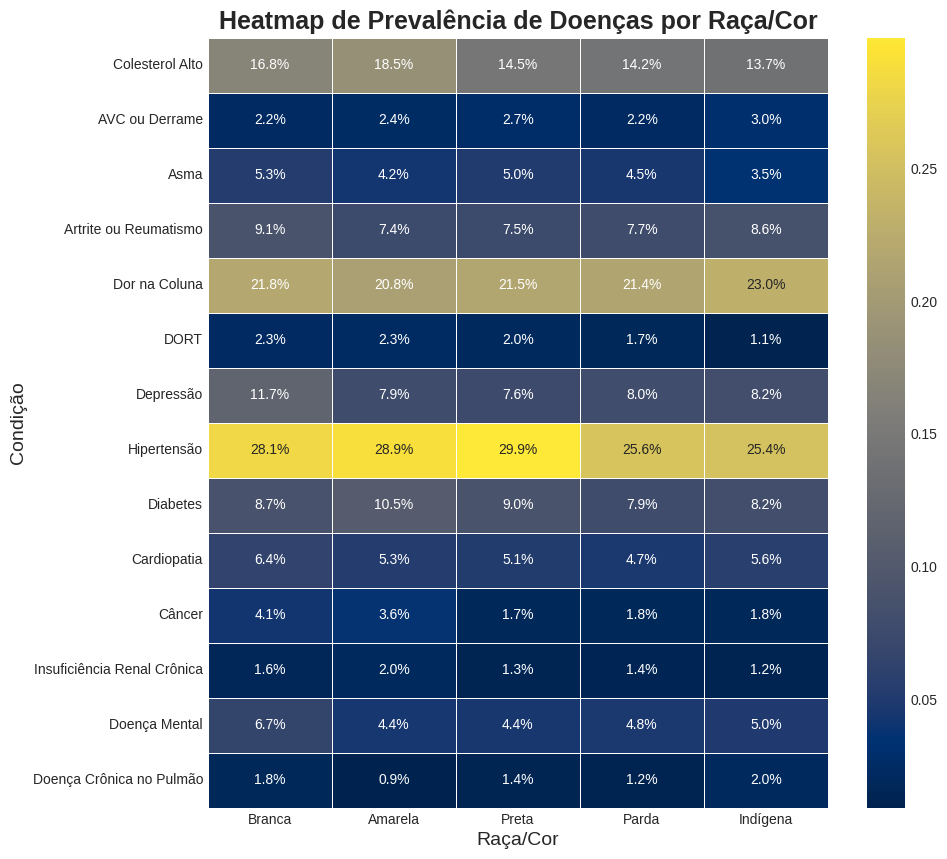

In [ ]:
# --- Geração do Heatmap ---
plt.figure(figsize=(10, 10))
sns.heatmap(
    prevalencia_por_raca.T, # Usamos .T para ter as doenças no eixo Y, facilitando a leitura
    annot=True,             # Adiciona os valores de prevalência nas células
    fmt=".1%",              # Formata os números como porcentagem
    cmap="cividis",           # Paleta de cores com bom contraste
    linewidths=.5
)

plt.title('Heatmap de Prevalência de Doenças por Raça/Cor', fontsize=18, fontweight='bold')
plt.xlabel('Raça/Cor', fontsize=14)
plt.ylabel('Condição', fontsize=14)
plt.show()

In [ ]:
grupos_principais = ['Branca', 'Parda', 'Preta', 'Amarela', 'Indígena']

regras_por_raca = {}

for grupo in grupos_principais:
    print(f"\n--- Gerando regras para o grupo: {grupo} ---")

    df_grupo = df[df[grupo] == 1][colunas_doencas]

    regras_grupo = gerar_regras_mlxtend(df_grupo, min_suporte=0.02, min_confianca=0.2)

    if regras_grupo.empty:
        print(f"Nenhuma regra encontrada com suporte 0.02. Tentando com suporte 0.015...")
        regras_grupo = gerar_regras_mlxtend(df_grupo, min_suporte=0.015, min_confianca=0.2)

    if not regras_grupo.empty:
        regras_por_raca[grupo] = regras_grupo
        tabela_para_plotar = regras_grupo.head(5)

        tabela_estilizada = tabela_para_plotar.style \
            .format({'suporte': '{:.2%}', 'confianca': '{:.2%}', 'lift': '{:.2f}'}) \
            .set_caption(f"Top 5 Regras de Associação - Grupo {grupo}") \
            .set_table_styles([
                {'selector': 'caption', 'props': [
                    ('caption-side', 'top'), ('font-size', '14pt'),
                    ('font-weight', 'bold'), ('color', '#f2f2f2'), ('margin-bottom', '10px')
                ]},
                {'selector': 'th', 'props': [
                    ('text-align', 'center'), ('font-weight', 'bold'),
                    ('background-color', '#000000')
                ]},
                {'selector': 'td', 'props': [
                    ('text-align', 'center'), ('border', '1px solid #eee')
                ]},
                {'selector': 'td:first-child, td:nth-child(2)', 'props': [('text-align', 'left')]}
            ]).hide(axis='index')
        display(tabela_estilizada)
    else:
        print(f"Nenhuma regra encontrada para o grupo '{grupo}' mesmo com limiares ajustados.")


--- Gerando regras para o grupo: Branca ---


antecedente,consequente,suporte,confianca,lift
Doença Mental,Depressão,3.28%,49.16%,4.19
Depressão,Doença Mental,3.28%,28.00%,4.19
Diabetes,"Hipertensão, Colesterol Alto",2.75%,31.47%,3.49
"Hipertensão, Colesterol Alto",Diabetes,2.75%,30.47%,3.49
Artrite ou Reumatismo,"Hipertensão, Dor na Coluna",2.62%,28.93%,3.38



--- Gerando regras para o grupo: Parda ---


antecedente,consequente,suporte,confianca,lift
Doença Mental,Depressão,2.15%,45.26%,5.64
Depressão,Doença Mental,2.15%,26.84%,5.64
"Hipertensão, Colesterol Alto",Diabetes,2.44%,31.79%,4.03
Diabetes,"Hipertensão, Colesterol Alto",2.44%,30.90%,4.03
"Hipertensão, Dor na Coluna",Artrite ou Reumatismo,2.27%,28.69%,3.71



--- Gerando regras para o grupo: Preta ---


antecedente,consequente,suporte,confianca,lift
"Hipertensão, Colesterol Alto",Diabetes,2.80%,31.75%,3.51
Diabetes,"Hipertensão, Colesterol Alto",2.80%,30.91%,3.51
"Hipertensão, Dor na Coluna",Artrite ou Reumatismo,2.34%,25.11%,3.36
Artrite ou Reumatismo,"Hipertensão, Dor na Coluna",2.34%,31.28%,3.36
"Artrite ou Reumatismo, Hipertensão",Colesterol Alto,2.02%,48.21%,3.32



--- Gerando regras para o grupo: Amarela ---


antecedente,consequente,suporte,confianca,lift
Depressão,Doença Mental,2.12%,26.92%,6.13
Doença Mental,Depressão,2.12%,48.28%,6.13
Artrite ou Reumatismo,"Hipertensão, Dor na Coluna",2.27%,30.61%,3.89
"Hipertensão, Dor na Coluna",Artrite ou Reumatismo,2.27%,28.85%,3.89
"Hipertensão, Colesterol Alto",Diabetes,3.64%,32.88%,3.14



--- Gerando regras para o grupo: Indígena ---


antecedente,consequente,suporte,confianca,lift
Depressão,Doença Mental,2.72%,33.33%,6.69
Doença Mental,Depressão,2.72%,54.55%,6.69
"Hipertensão, Dor na Coluna",Artrite ou Reumatismo,2.87%,31.67%,3.68
Artrite ou Reumatismo,"Hipertensão, Dor na Coluna",2.87%,33.33%,3.68
Artrite ou Reumatismo,Depressão,2.57%,29.82%,3.66


In [ ]:
def calcular_distribuicao_carga_doencas(df):

    df_calc = df.copy()

    if 'N_Doencas' not in df_calc.columns:
        df_calc['N_Doencas'] = df_calc[colunas_doencas].sum(axis=1)

    bins = [-1, 0, 1, 2, float('inf')]
    labels = ['0 Doenças', '1 Doença', '2 Doenças', '3+ Doenças']
    df_calc['Carga de Doenças'] = pd.cut(df_calc['N_Doencas'], bins=bins, labels=labels)

    distribuicoes = {}
    for raca in colunas_raca:
        df_grupo = df_calc[df_calc[raca] == 1]

        distribuicoes[raca] = df_grupo['Carga de Doenças'].value_counts(normalize=True)

    tabela_final = pd.DataFrame(distribuicoes).T.fillna(0)

    for label in labels:
        if label not in tabela_final.columns:
            tabela_final[label] = 0

    return tabela_final[labels]

def estilizar_tabela_carga_doencas(dados_distribuicao, titulo):
    if dados_distribuicao.empty:
        print(f"Nenhum dado para exibir na tabela: {titulo}")
        return
    print(f"\n--- {titulo} ---")
    tabela_estilizada = dados_distribuicao.style \
        .format("{:.1%}") \
        .set_caption(titulo) \
        .background_gradient(cmap='viridis', axis=1) \
        .set_table_styles([
            {'selector': 'caption', 'props': [
                ('caption-side', 'top'), ('font-size', '14pt'),
                ('font-weight', 'bold'), ('color', '#f2f2f2'), ('margin-bottom', '10px')
            ]},
            {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
            {'selector': 'th.row_heading', 'props': [('text-align', 'left')]},
            {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid #eee')]}
        ])
    display(tabela_estilizada)

def plotar_grafico_carga_doencas_empilhado(dados_distribuicao, titulo):
    if dados_distribuicao.empty:
        print(f"Nenhum dado para plotar o gráfico: {titulo}")
        return
    ax = dados_distribuicao.plot(
        kind='barh', stacked=True, figsize=(12, 8),
        colormap='viridis', width=0.8
    )
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if width > 0.05:
            ax.text(x + width/2, y + height/2, f'{width:.0%}',
                    ha='center', va='center', fontsize=11,
                    color='white', fontweight='bold')
    plt.title(titulo, fontsize=18, fontweight='bold')
    plt.xlabel('Proporção de Indivíduos', fontsize=14)
    plt.ylabel('Raça/Cor', fontsize=14)
    plt.legend(title='Carga de Doenças', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    plt.tight_layout()
    plt.show()

Gerando análise da Distribuição da Carga de Comorbidades por Raça/Cor...

--- Tabela: Proporção de Indivíduos por Carga de Doenças ---


Carga de Doenças,0 Doenças,1 Doença,2 Doenças,3+ Doenças
Branca,40.3%,26.2%,15.7%,17.8%
Amarela,42.1%,25.0%,17.1%,15.8%
Preta,43.7%,26.3%,14.8%,15.2%
Parda,46.3%,25.9%,13.9%,14.0%
Indígena,46.4%,25.4%,12.2%,16.0%


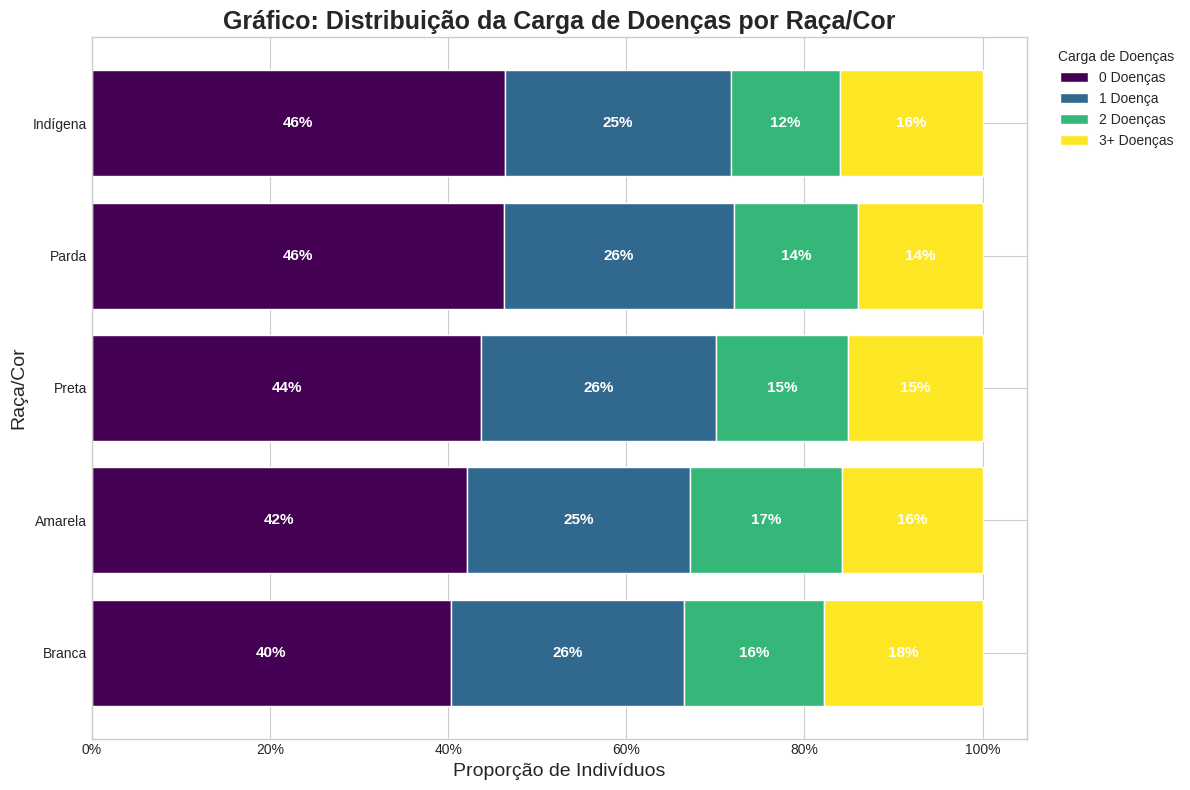

In [ ]:
print("Gerando análise da Distribuição da Carga de Comorbidades por Raça/Cor...")

dados_distribuicao = calcular_distribuicao_carga_doencas(df)

titulo_tabela = "Tabela: Proporção de Indivíduos por Carga de Doenças"
estilizar_tabela_carga_doencas(dados_distribuicao, titulo_tabela)

titulo_grafico = "Gráfico: Distribuição da Carga de Doenças por Raça/Cor"
plotar_grafico_carga_doencas_empilhado(dados_distribuicao, titulo_grafico)

## 1️⃣0️⃣ Conclusão

Neste projeto, a gente mergulhou em uma base de dados de saúde para entender como as doenças se conectam e o que muda quando olhamos para diferentes grupos de pessoas, como homens e mulheres, jovens e idosos, e por raça/cor. Usando várias ferramentas e gráficos, encontramos alguns padrões bem importantes.

Aqui estão os principais achados do nosso trabalho:

**Aqui estão os principais achados do nosso trabalho:**

*   **Homens e Mulheres Adoecem de Formas Diferentes**:
Uma das primeiras coisas que ficou clara é que o perfil de saúde varia muito com o gênero.

  * **Mulheres**: No geral, elas mostraram ter uma carga maior de *doenças crônicas*, principalmente problemas de dor (como *Artrite* e *Dor na Coluna*), saúde mental (*Depressão*) e condições como *Colesterol Alto* e *Obesidade*.

  * **Homens**: Eles apresentaram uma frequência bem maior de hábitos de risco, como consumo de Álcool e Tabaco. Também são mais propensos a ter Sobrepeso.

---
* **O "Combo Metabólico" é o Grande Vilão**:
A descoberta mais forte e que apareceu em quase toda análise foi a forte ligação entre *Hipertensão*, *Diabetes*, *Colesterol Alto* e *IMC elevado* (*Sobrepeso/Obesidade*). Essas condições raramente andam sozinhas. É como um "combo": se uma pessoa tem uma delas, a chance de ter as outras é muito alta. Isso mostra que o tratamento precisa olhar para o paciente como um todo, e não só para uma doença isolada.

---
* **Ficar Mais Velho Realmente Piora as Coisas**:
Isso pode parecer óbvio, mas nossos gráficos provaram isso. Vimos uma "escada" clara: quanto mais avançada a faixa etária, maior o número médio de doenças por pessoa. A análise de cluster também mostrou que os "perfis de risco" dos pacientes ficam muito mais complexos com o tempo, com um acúmulo de múltiplas doenças nos grupos mais velhos.

---
* **Existem Diferenças de Saúde Importantes entre Raça/Cor**:
A análise mostrou que a saúde não é igual para todos os grupos. No nosso estudo, por exemplo, o grupo de pessoas Brancas teve a maior porcentagem de indivíduos com 3 ou mais doenças. É fundamental entender que isso provavelmente não tem a ver com **biologia**, mas sim com fatores sociais, econômicos e de acesso à saúde que afetam cada grupo de forma diferente.

---
* **Dois Achados "Surpresa" que Valem a Pena Mencionar**:
  * **Saúde Mental é Chave**: A ligação entre *Depressão* e *Doença Mental* foi uma das mais fortes de toda a análise, superando até algumas associações clássicas. Isso é um sinal claro de que a saúde mental é uma parte central da saúde geral.
  * **Ser Magro Demais Também Pode Ser um Sinal de Alerta**: Vimos que o grupo de *Baixo Peso* tinha, em média, mais doenças que o de *Peso Normal*. A explicação mais provável é que muitas doenças crônicas graves acabam fazendo a pessoa perder peso (e não o contrário).